# RAW Time-Signal Measurements

## Loading

In [1]:
# Basic Plotting libraries
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Math / Science Libraries
import pandas as pd
import numpy as np
import scipy

import logging # System Modules
import re # Regular Expressions
from glob import glob

logging.basicConfig(level=logging.WARNING)

# Plotting parameters
params = {
    'figure.dpi': 300,
    'figure.figsize': (20,15),
    'figure.subplot.hspace': 0.3,
    'figure.subplot.wspace': 0.3,
    'savefig.transparent': False,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
}
matplotlib.rcParams.update(params)


logger = logging.getLogger('EVA-SR830DAQ')

%load_ext autoreload

In [2]:
import os
os.chdir('../../ana')
os.getcwd()

'/Users/jp/Projects/Code/lab-book/ana'

### Reload Modules

In [3]:
%reload_ext autoreload
%autoreload 1
logging.basicConfig(level=logging.DEBUG)
import ana
from spectrumanalyzer import SpectrumAnalyzer


### Define Functions

In [4]:
default_styling = [['science'], {'context': 'paper', 
                                 'style': 'dark',
                                 'palette': 'bright',
                                }]
def set_style(styling=default_styling):
    plt_style, sns_style = styling
    plt.style.use(*plt_style)
    sns.set(**sns_style)
set_style()

#### Plot Spectrum Hysteresis

In [5]:
def plot_spectrum_hyst(nr1, nr2, **kwargs):
    meas = {}
    meas[0] = mfn_measurements[nr1].measurements
    meas[1] = mfn_measurements[nr2].measurements
    n1, n2 = len(meas[0]), len(meas[1])
    sns.set_palette(sns.color_palette("RdBu", n1+n2))
    fig, (ax1) = plt.subplots(nrows=1, figsize=(16,10))
    colors = 'rb'
    for i,nr in enumerate([nr1, nr2]):
        c = colors[i]
        for field in mfn_measurements[nr].data.sort_values('Field')['Field'].unique():
            s = meas[i][field].avg_spec
            ax1.plot(field, s.S.sum(), c+'o')
    ax1.set_title('$\\sum_f$ Noise Power (m%s Red / m%s Blue)' % (nr1, nr2))
    if kwargs.get('log', True):
        ax1.set_yscale('log')

### Define Variables

Do this only Once! After initialization, these Variables will contain all measurement data and can be used for different evaluations!

In [19]:
#df, spec = {}, {}
mfn_measurements = {}

In [7]:
def load_meas_info(file='data/mfn_info.csv'):
    meas_info = pd.read_csv(file, index_col=0)
    meas_info.index.name = 'Nr'

    # Drop Measurements where an error occured.
    meas_info = meas_info[meas_info['Error'] != True]
    meas_info.drop('Error', axis=1, inplace=True)
    return meas_info

meas_info = load_meas_info()
meas_info

Struct  Angle                                  Voltage  Frequency  Temp  \
Nr                                                                              
430  Plusses     45                                      2.5         17    30   
431  Plusses     45                                      2.5         17    30   
433  Plusses     45                                      2.5        113    30   
434  Plusses     45                                      2.5        113    30   
435  Plusses     45                                        5        113    30   
..       ...    ...                                      ...        ...   ...   
504  Plusses     90                                        5        113    15   
505  Plusses     90                                        5        113    15   
506  Plusses     90  0.5/1.0/1.5/2.0/2.5/3.0/3.5/4.0/4.5/5.0         17    15   
507  Plusses     90                                        5         17    15   
508  Plusses     90                  2.5/3.0/3.5/4.0/4.5/5.0         17    15   

     Preamp  Rate    Time   Dir                  Limit     dB  timeconstant  \
Nr                                                                            
430   False     8   600.0  Down                    0.2  0.010         0.100   
431   False     8   600.0    Up                    0.2  0.010         0.100   
433    True    16  1024.0    Up                    0.1  0.002         0.100   
434    True    32   512.0    Up                    0.2  0.020         0.100   
435    True    16  1024.0  Down                    0.1  0.005         0.100   
..      ...   ...     ...   ...                    ...    ...           ...   
504   False     8     NaN    Up  0.5/0.75/1.0/1.25/1.5    NaN         0.003   
505   False     8     NaN    Up  0.5/0.75/1.0/1.25/1.5    NaN         0.100   
506   False     8     NaN    Up                    0.1    NaN         0.100   
507   False     8     NaN    Up                  0.025    NaN         0.100   
508   False     8     NaN    Up                    0.1    NaN         0.100   

            SR  
Nr              
430        NaN  
431        NaN  
433        NaN  
434        NaN  
435        NaN  
..         ...  
504          2  
505          2  
506          5  
507  2/1.5/1/0  
508          5  

[66 rows x 13 columns]

### Load Data

This takes a long time, if calculated for each Measurement `meas_info.index`! Instead use single numbers!

In [20]:
%%time
num = 64
for nr in [446 + _ for _ in range(2)]: #meas_info.index: #
    tc = meas_info['timeconstant'].loc[nr]
    mfn_measurements[nr] = ana.MFN(nr, timeconstant=tc, equalize_length=False)


CPU times: user 4.64 s, sys: 136 ms, total: 4.77 s
Wall time: 4.98 s


## Search data manually

In [21]:
mfn_measurements.keys()

dict_keys([446, 447])

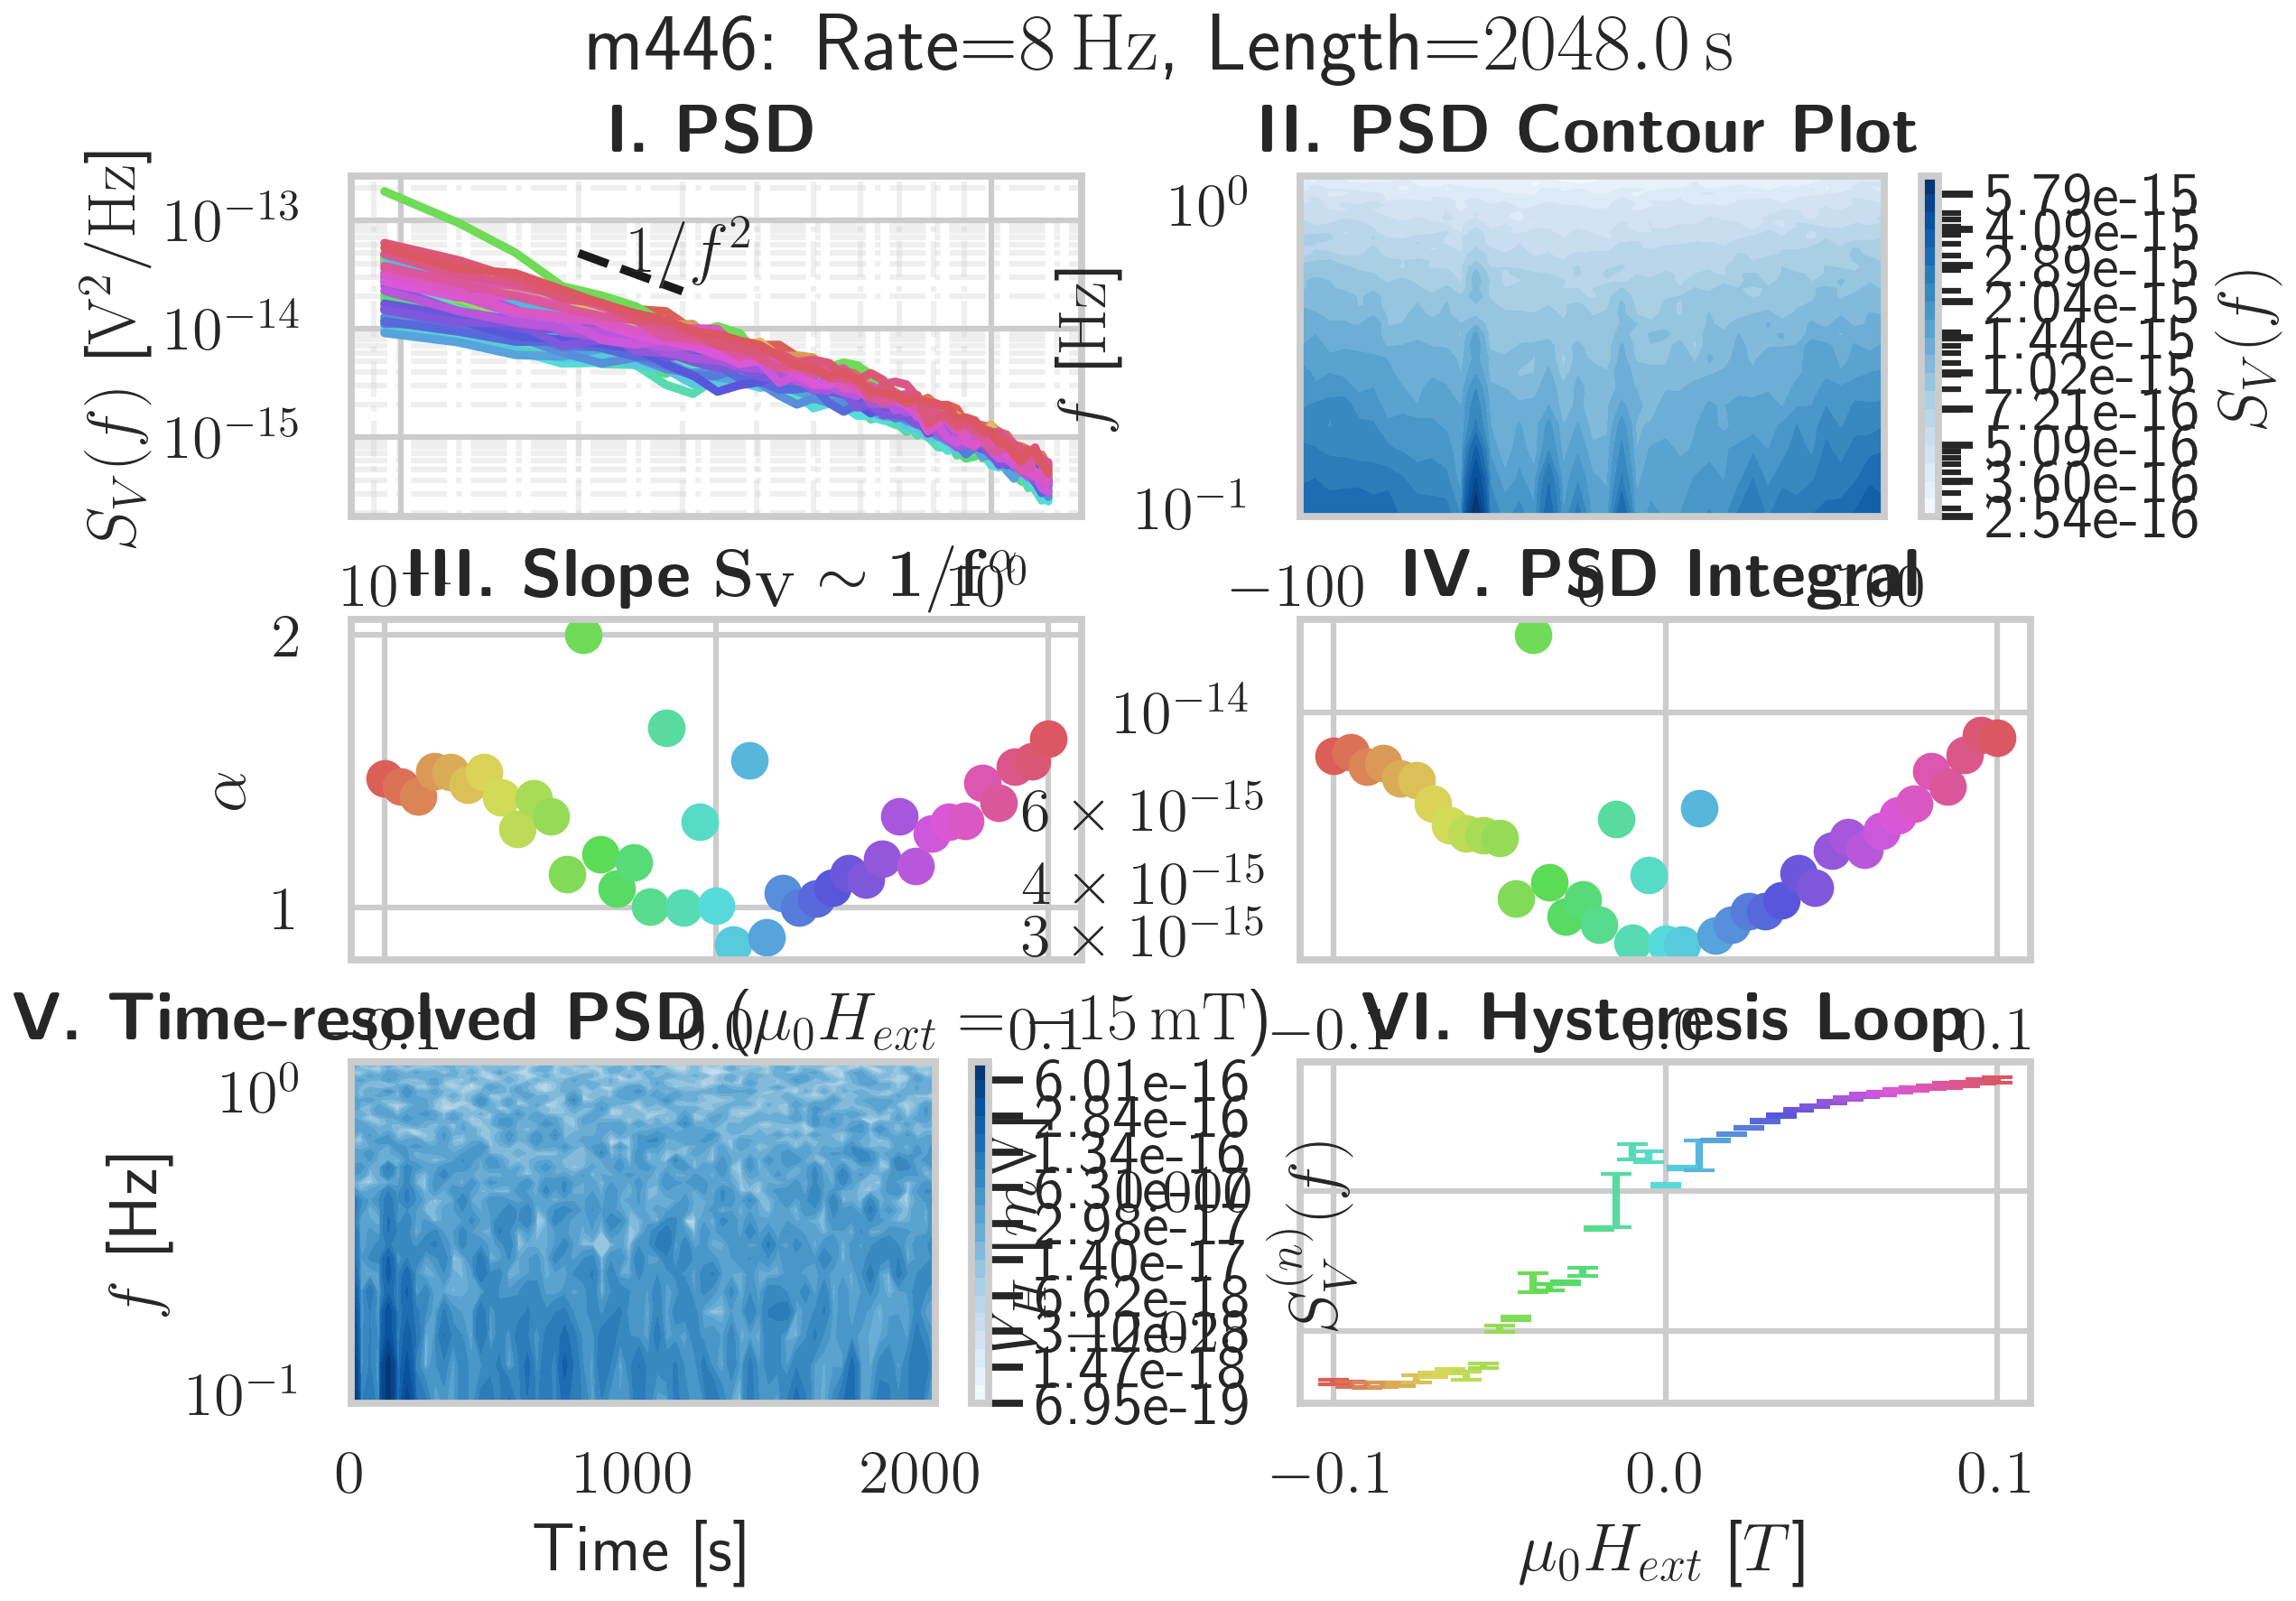

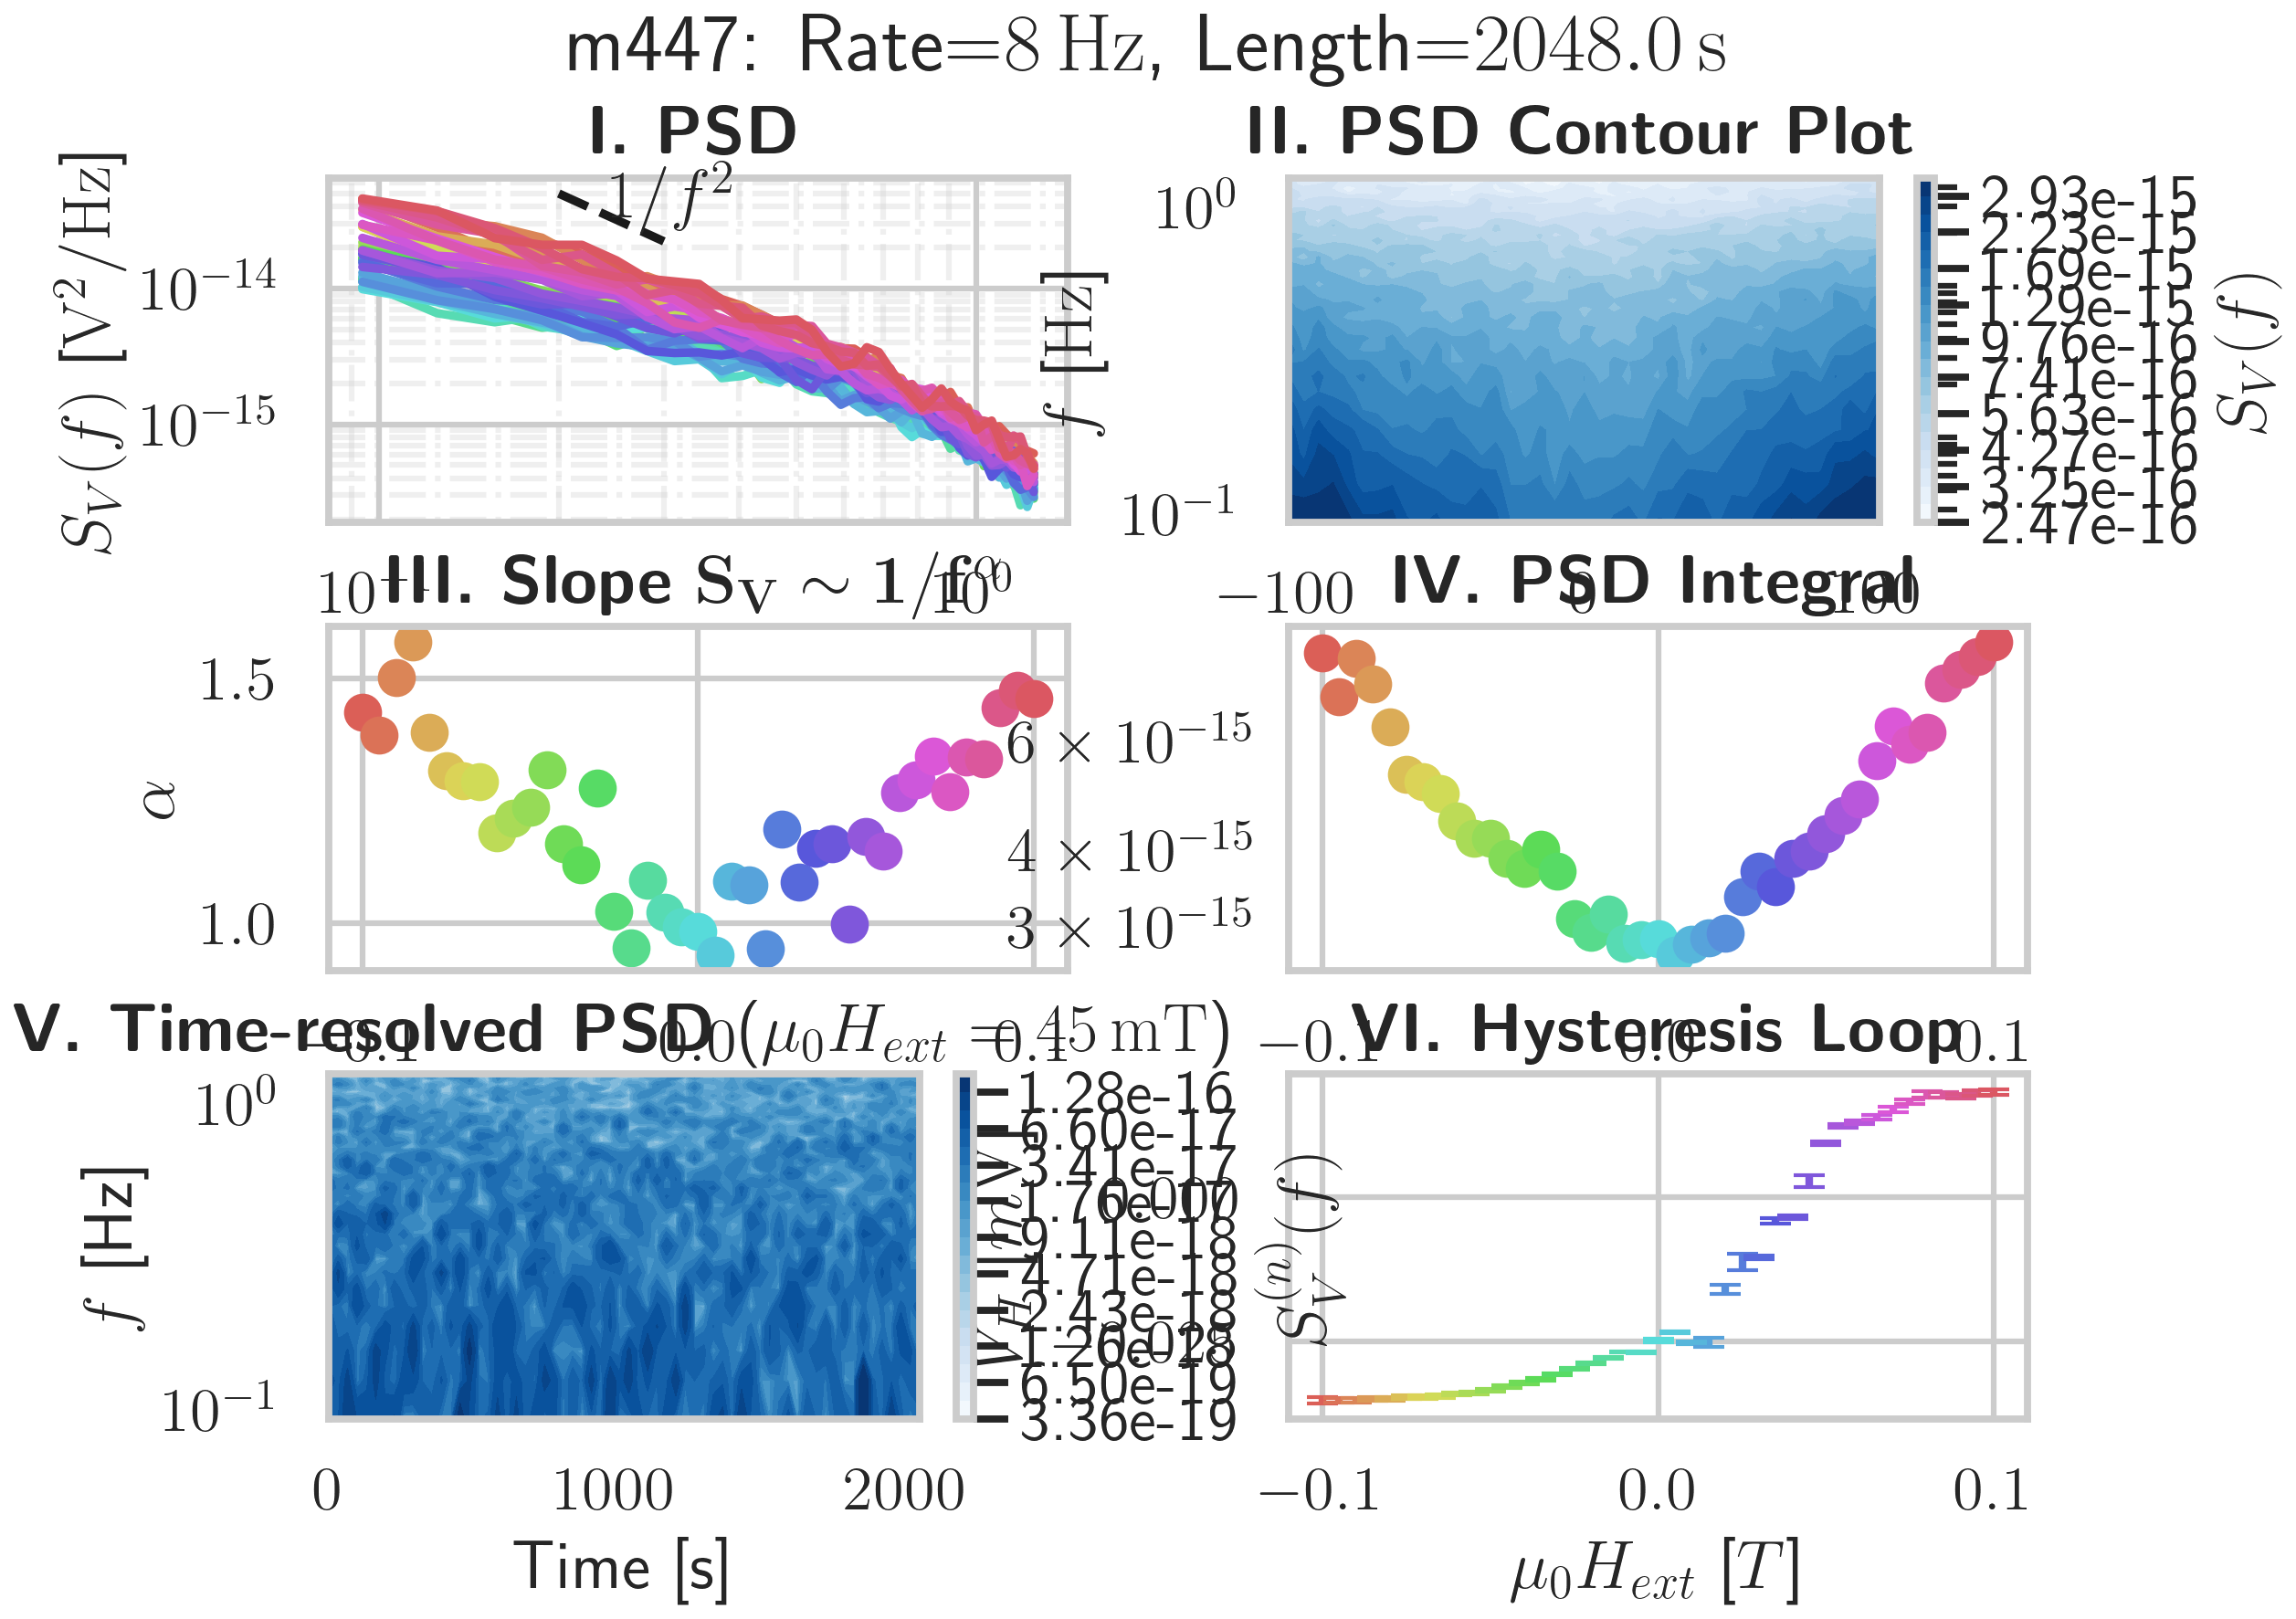

In [22]:
for nr in mfn_measurements.keys():
    stat = mfn_measurements[nr].data.groupby('Field').describe()['Vx']
    idxmax = (stat['max'] - stat['min']).idxmax()

    try:
        mfn = mfn_measurements[nr]
        mfn.plot_info(show_field=idxmax, numlevels=20)
    except Exception as e:
        print('Error processing Nr. %s: %s' % (nr, e))

### Fit Data

In [23]:
df_fit = pd.DataFrame()
for field in np.sort(mfn.data.Field.unique()):
    signal = mfn.data.query('Field == @field')
    mean = signal.Vx.mean()
    signal.loc[:,'fittedVx'] = signal.Vx - mean
    
    df_fit = pd.concat([df_fit, signal])

/opt/homebrew/Caskroom/miniforge/base/envs/metal-tf-3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<AxesSubplot:xlabel='Field', ylabel='fittedVx'>

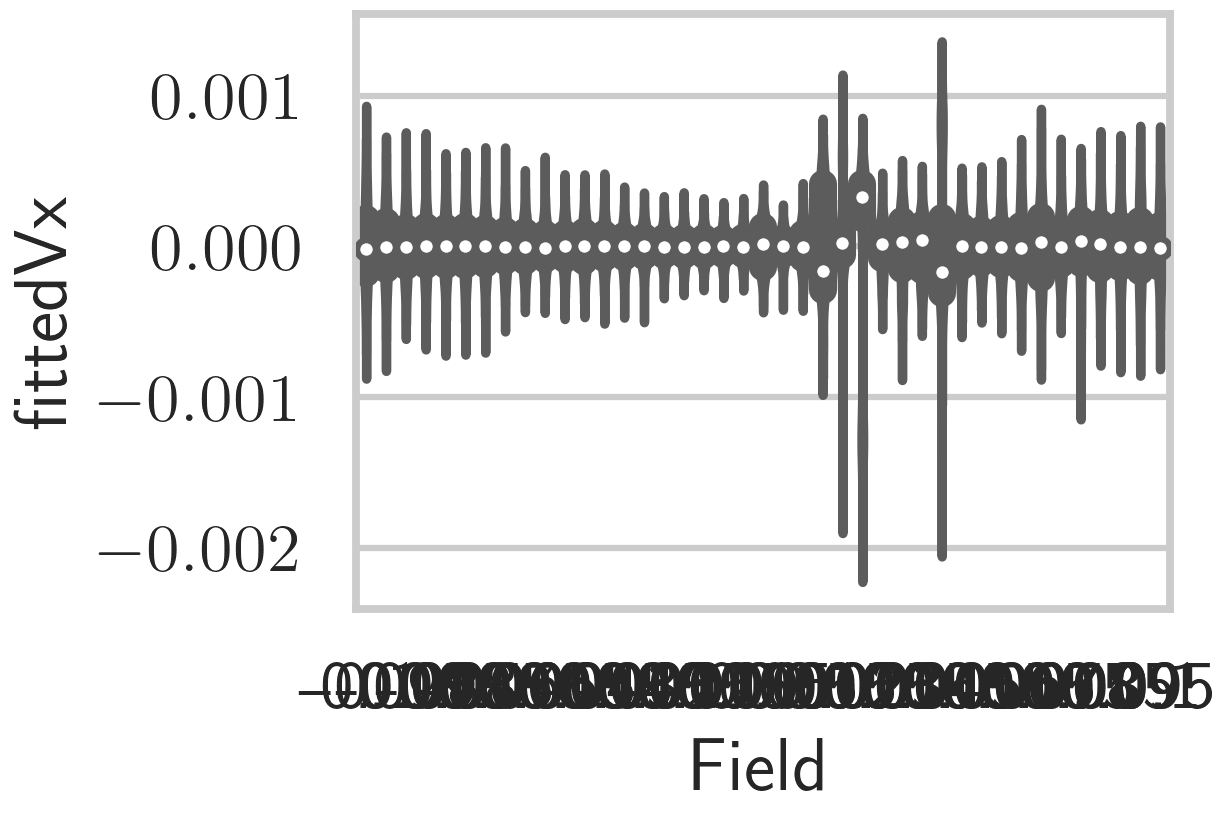

In [24]:
sns.violinplot(x="Field", y='fittedVx', data=df_fit)

### Split Data into Groups (e.g. 5x8)

In [25]:
field_groups = df_fit.groupby('Field')

In [26]:
neg_saturation = -.2
field_range = .4
steps = 4
df = pd.DataFrame()
for i in range(steps):
    stepsize = (field_range/steps)
    start = neg_saturation + i*stepsize
    end = start + stepsize
    df_tmp = df_fit.query('Field >= @start and Field < @end')
    df_tmp.reset_index(inplace=True)
    df_tmp.loc[:,'Group'] = i
    for j, f in enumerate(np.sort(df_tmp.Field.unique())):
        df_tmp.loc[df_tmp.query('Field == @f').index,'SubGroup'] = j
        df_tmp.loc[df_tmp.query('Field == @f').index,'x'] = df_tmp.loc[
            df_tmp.query('Field == @f').index,'fittedVx'] + i*.2
    df = pd.concat([df, df_tmp])

ValueError: cannot set a frame with no defined index and a scalar

### Function to save plots

In [27]:
def save_plot(name, kind='pgf', dpi=None):
    if not os.path.exists('img'):
        os.makedirs('img')
    if kind == 'pgf':
        matplotlib.use("pgf")
        matplotlib.rcParams.update({
            "pgf.texsystem": "pdflatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
        })

    plt.show()
    if dpi == None:
        plt.savefig('img/%s.%s' % (name, kind))
    else:
        plt.savefig('img/%s.%s' % (name, kind), dpi=dpi)

### Plot kde of multiple fields

In [28]:
factor = 1e3
plt.style.use(['science'])
sns.set('paper', 'white', rc={"axes.facecolor": (0, 0, 0, 0)})
steps = 4
for i in range(steps):
    stepsize = (field_range/steps)
    start = neg_saturation + i*stepsize
    end = start + stepsize
    df_tmp = df.query('Field >= @start and Field < @end')
    df_tmp.loc[:,'fittedVx'] *= factor

    # Initialize the FacetGrid object
    pal = sns.dark_palette(color="blue", n_colors=10, input='huls')
    g = sns.FacetGrid(df_tmp, row="Field", hue="Field", aspect=5, height=.8, palette=pal)
    g.map(sns.kdeplot, "fittedVx", clip_on=True, shade=True, alpha=1, lw=1.5, bw=.2)
    g.map(sns.kdeplot, "fittedVx", clip_on=True, color="w", lw=2, bw=.2)
    # g.map(sns.distplot, "fittedVx", hist=True, norm_hist=True, hist_kws={'alpha': .5})
    g.map(plt.axhline, y=0, lw=2, clip_on=True).set(xlim=(-1.3,1.3))

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .3, label, fontweight="bold", color=color,
                ha="left", va="center", fontsize=16,
                transform=ax.transAxes)


    g.map(label, "fittedVx")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.3)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])#, xticks=[-100 + 50*_ for _ in range(5)])
    g.despine(bottom=True, left=True)
    unit = 'mT' if factor == 1e3 else '\\muT' if factor == 1e6 else 'T'
    plt.gca().set_xlabel('$V_H$ [$\\mathrm{%s}$]' % unit)
    save_plot('m487: histogram_%s' % i, 'png')

UndefinedVariableError: name 'Field' is not defined

#### Plot histogram of multiple fields

In [29]:
plt.style.use(['science'])
sns.set('paper', 'white', rc={"axes.facecolor": (0, 0, 0, 0)})

steps = 8
for i in range(steps):
    stepsize = (.2/steps)
    start = -.105 + i*stepsize
    end = start + stepsize
    df_tmp = df.query('Field > @start and Field < @end')
    df_tmp.fittedVx *= factor

    # Initialize the FacetGrid object
    pal = sns.dark_palette(color="blue", input='huls')
    # sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df_tmp, row="Field", hue="Field", aspect=5, height=.8, palette=pal)
    g.map(sns.distplot, "fittedVx", hist=True)
    g.map(sns.distplot, "fittedVx", kde=True)
    g.map(plt.axhline, y=0, lw=2, clip_on=True)#.set(xlim=(-.11,.1))

    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .3, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "Vx")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.3)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])#, xticks=[-100 + 50*_ for _ in range(5)])
    g.despine(bottom=True, left=True)
    plt.gca().set_xlabel('$V_x$ [$\\mathrm{mT}$]')
    

UndefinedVariableError: name 'Field' is not defined

In [177]:
nr

450

## Plot Data

### Default Info about Measurements

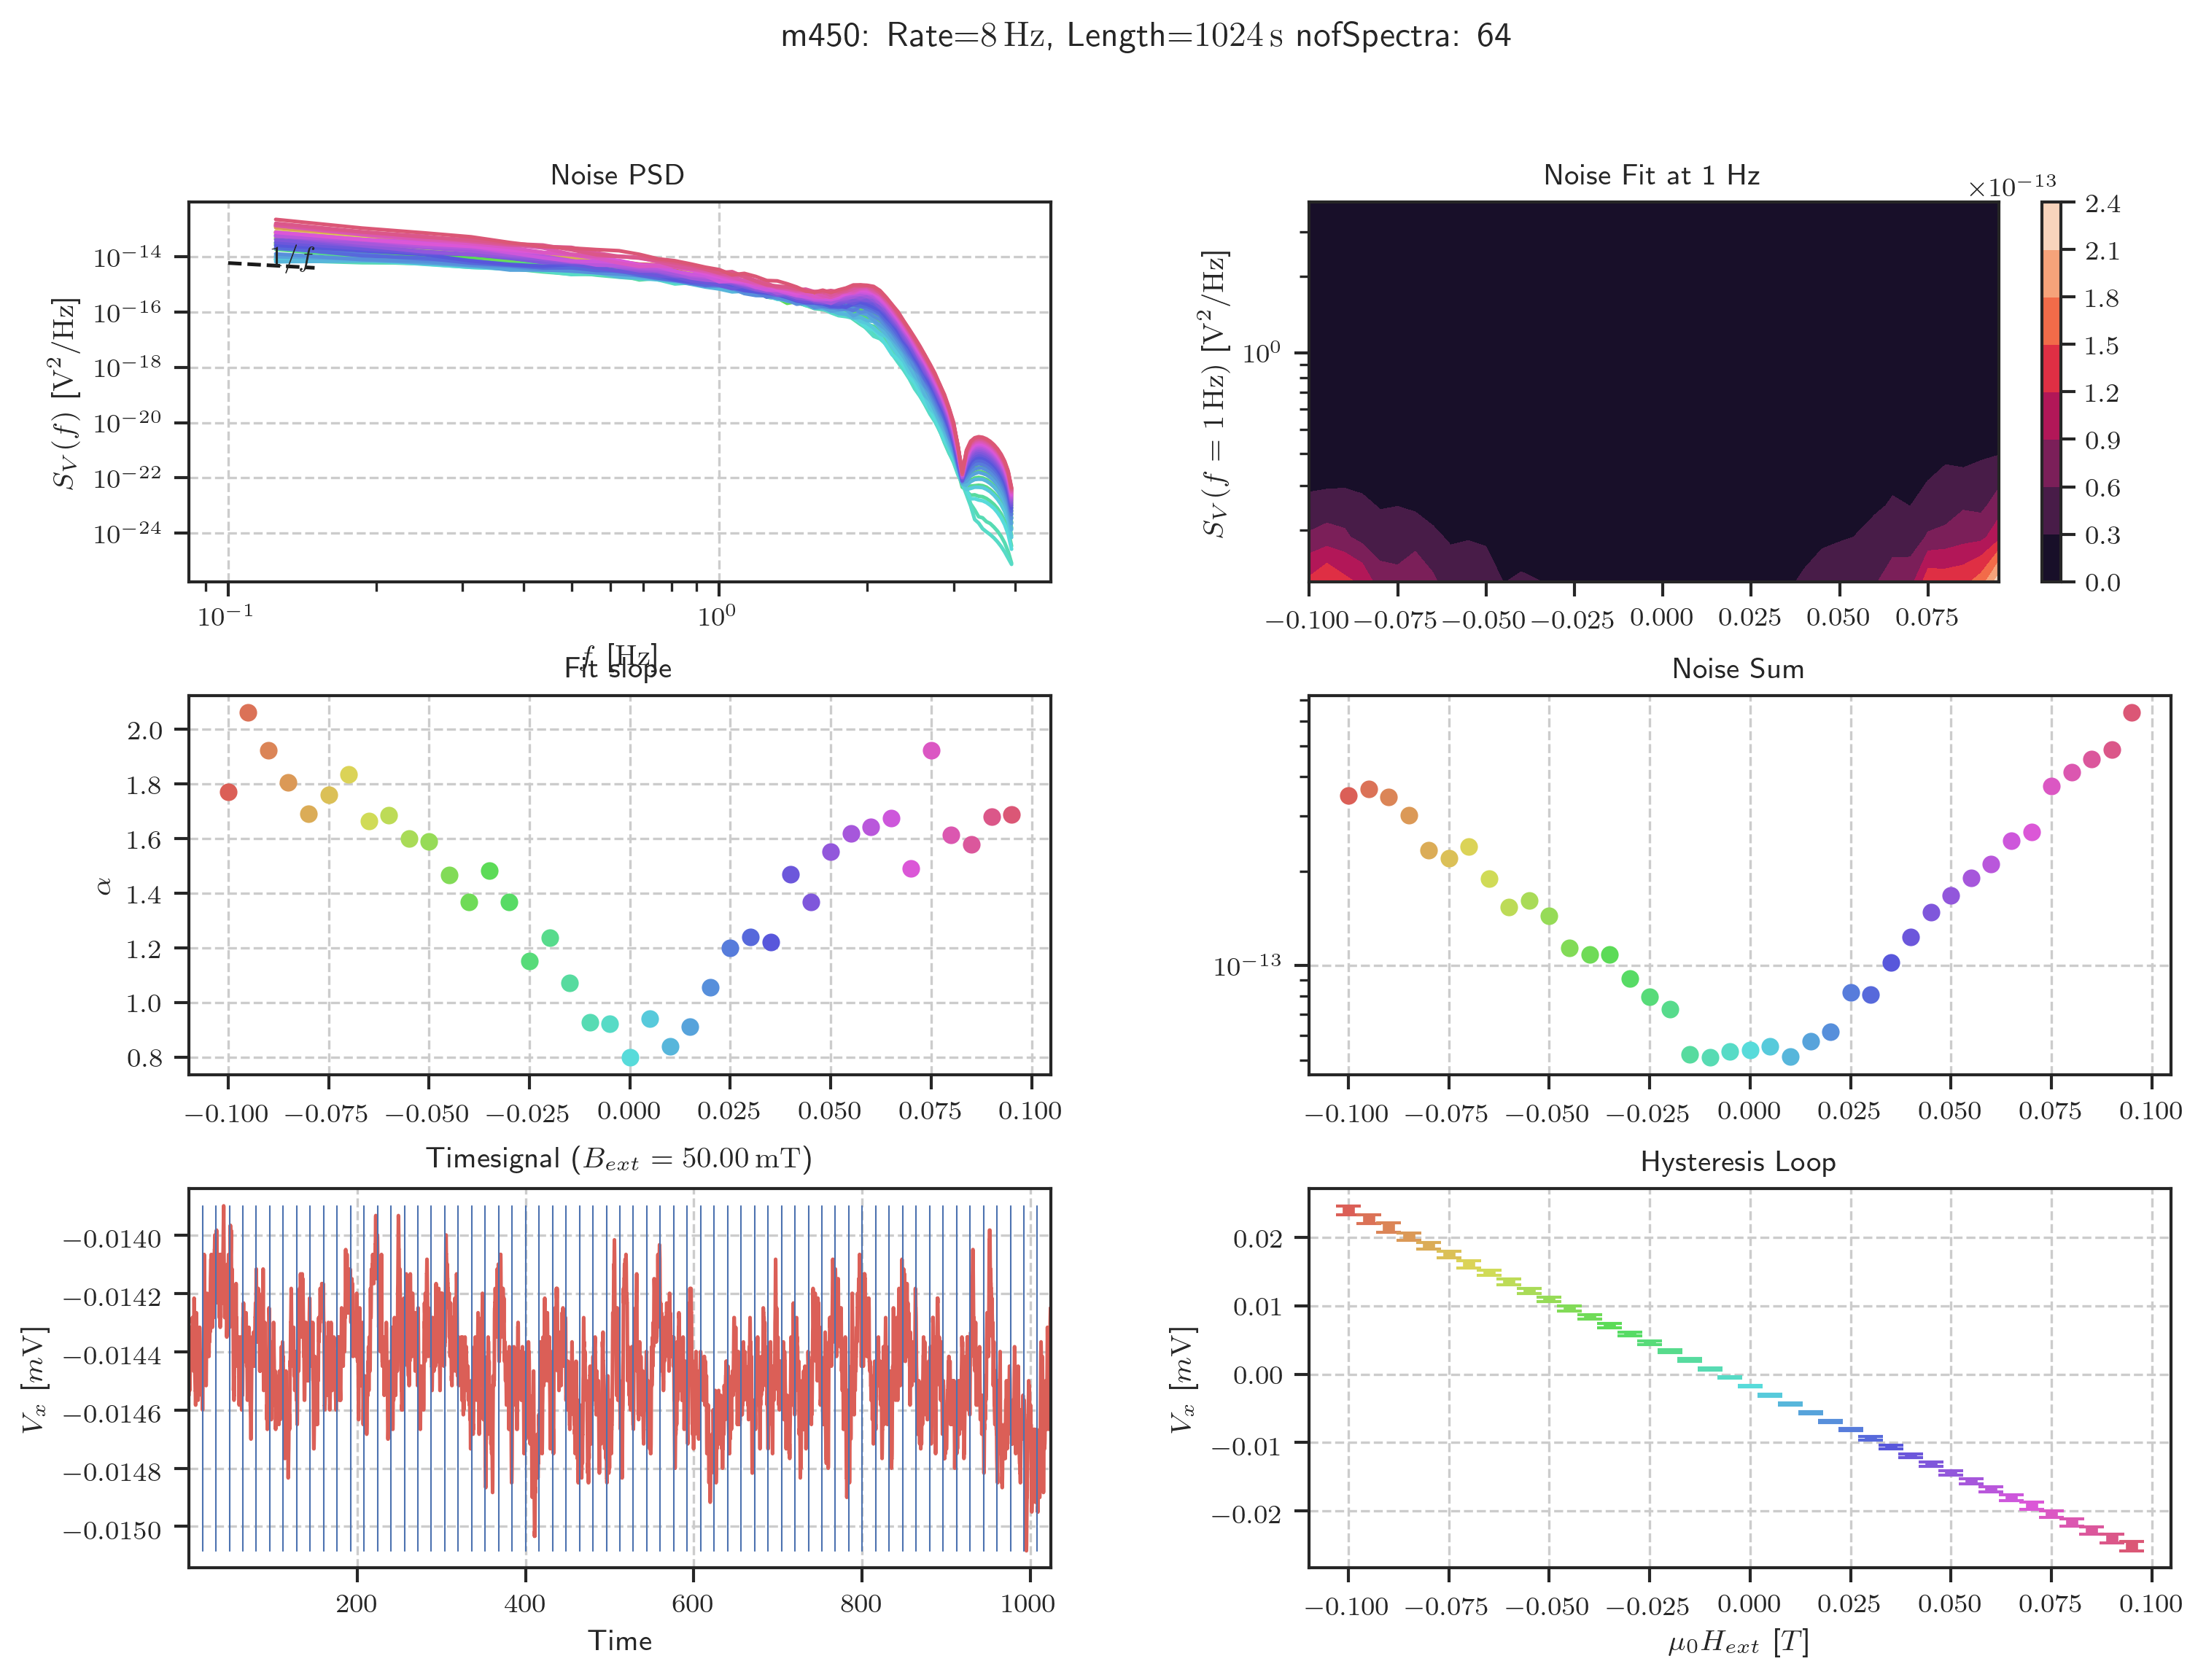

In [276]:
%%time
eva.set_sns(default=True, grid=True, 
            size='paper', style='ticks', latex=True)
for nr, sf in [
     (450, .05)
    #(446,-0.015),
        ]:
    fit = 10
    xymin = (1e-1, 6e-15) if (meas_info.loc[nr]['Time'] > 1024) else (3e-1, 6e-15)
    rate = meas_info.loc[nr]['Rate']
    length = int(df[nr].groupby('Field').max().Time.max())
    if length != meas_info.loc[nr]['Time']:
        logging.warning('Meas-Length: %ss \t Meas-Time: %ss' % (length, meas_info.loc[nr]['Time']))
    
    plot_info(df[nr], spec[nr], fit_range=fit, xymin=xymin, nr=nr, 
              rate=rate, length=length, show_field=sf, 
              add_info='nofSpectra: %s' % num,
              fields=np.round(np.arange(-.1, .1, .005), 3),
              num_first_spectra=num)
    plt.savefig('m%s_info_nofSpectra-%s.png' % (nr, num))


### Plot First and Second Spectrum

In [ ]:
eva.set_sns(notebook=True, size='notebook', grid=True)
for nr in [437]:
    plot_first_and_second(df[nr], spec[nr], nr=nr)
    plt.savefig('m%s_first_and_second_nofSpectra-%s.png' % (nr, num))


#### Plot Second Spectrum of specific fields

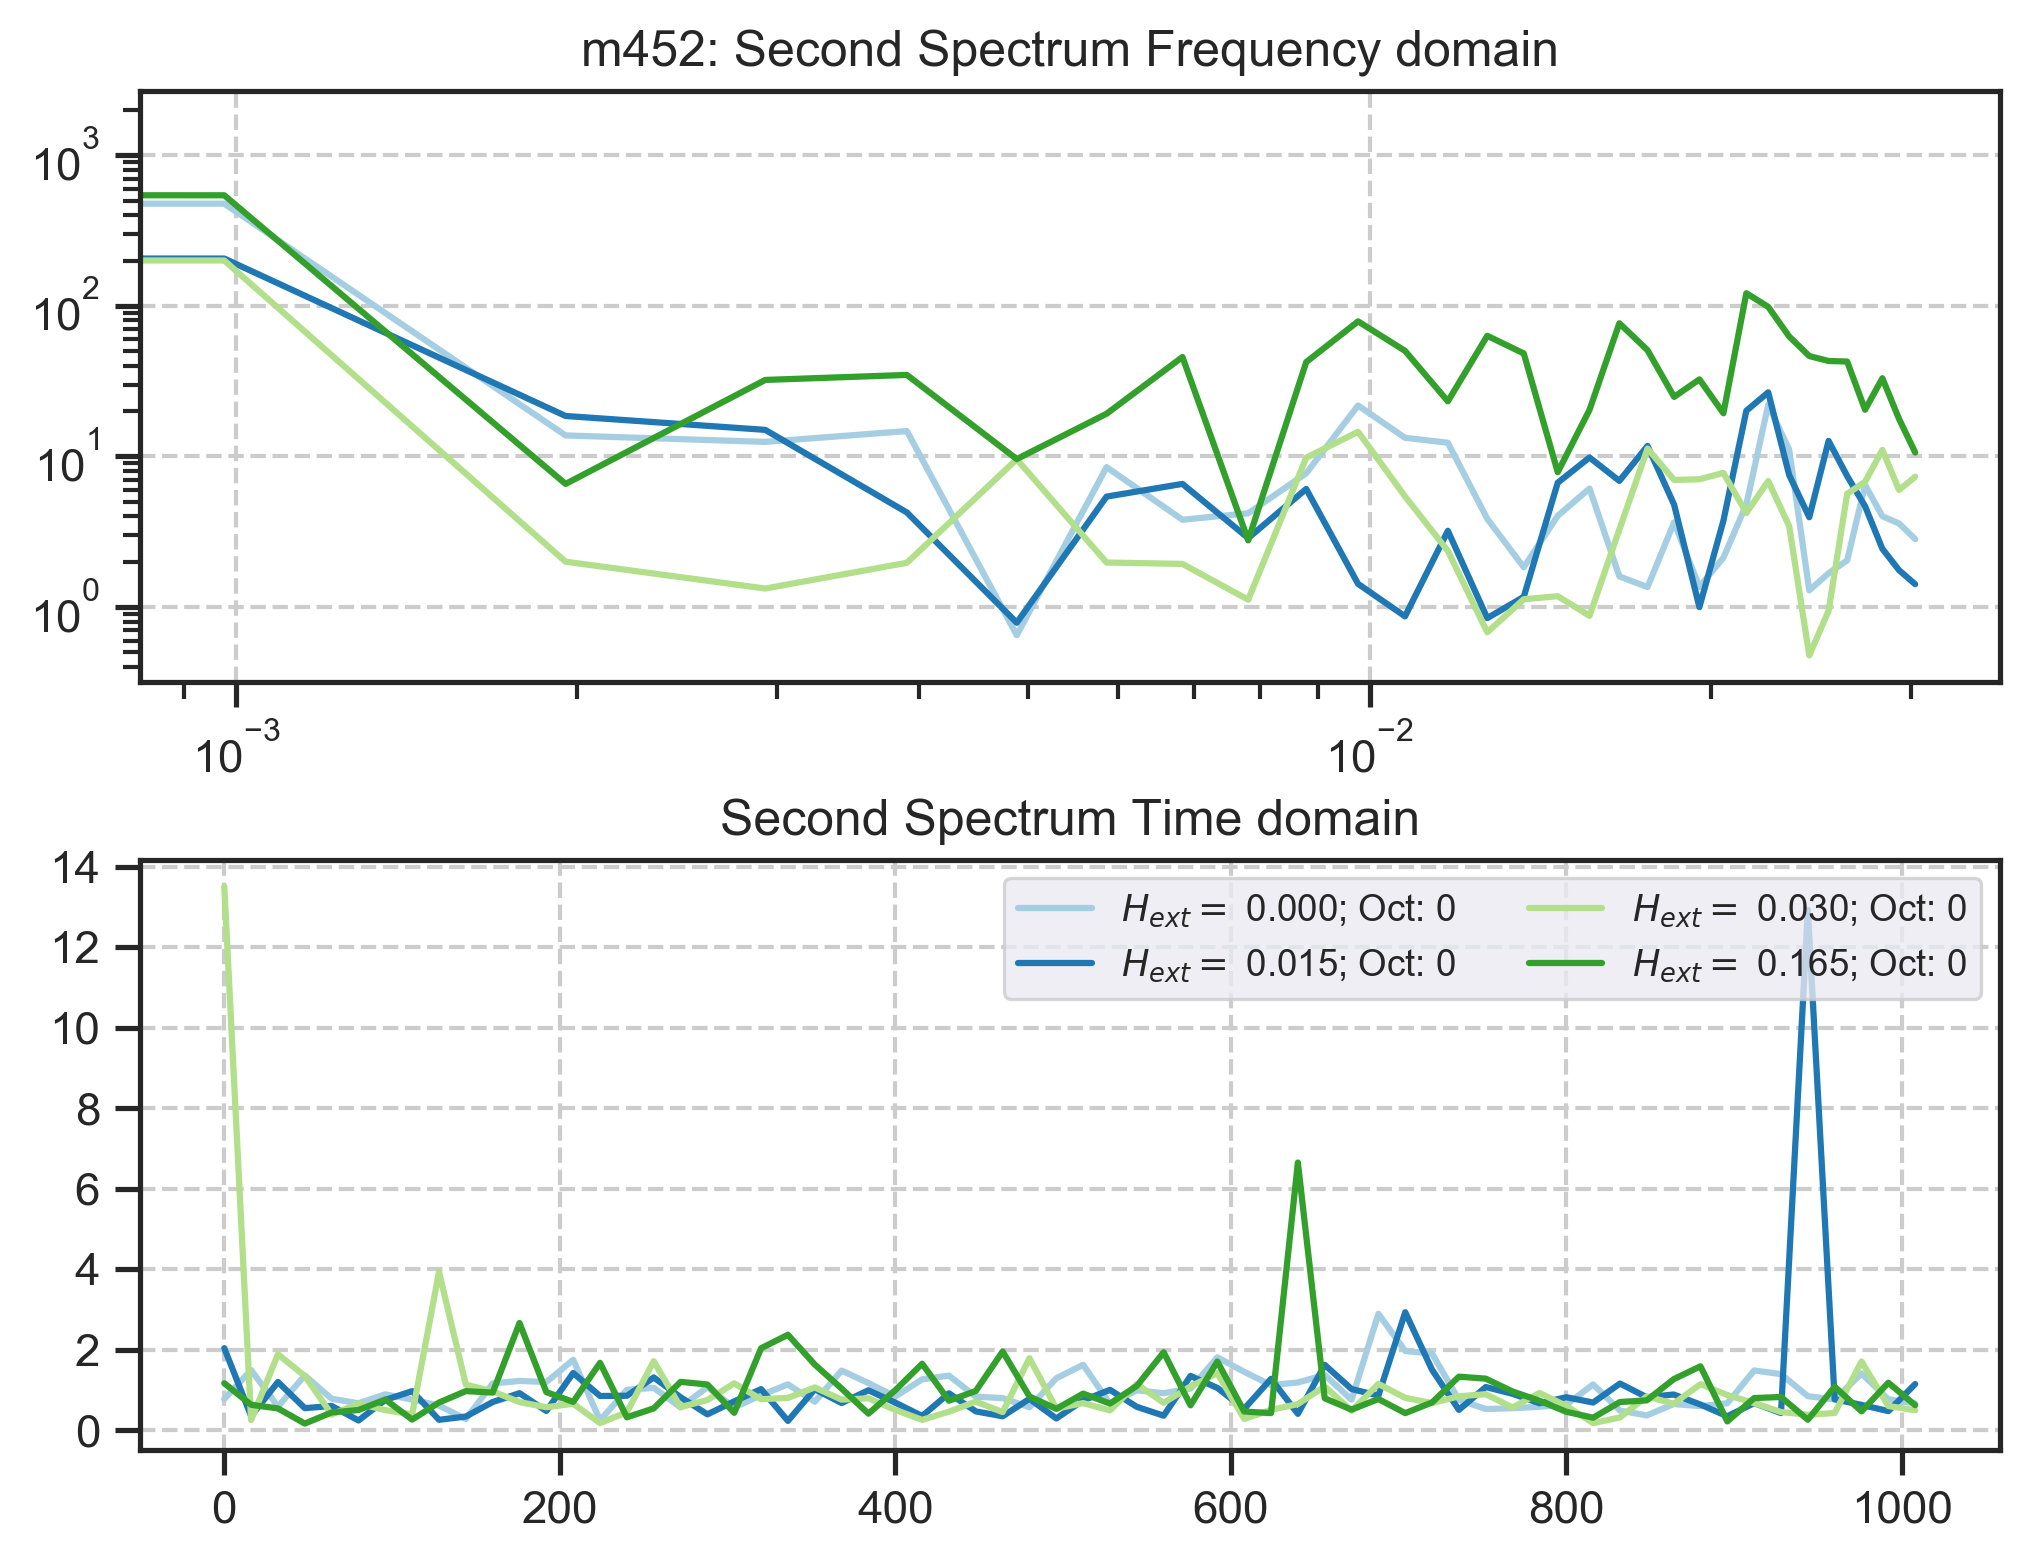

In [692]:
eva.set_sns(notebook=True, palette='Paired', grid=True)
nr = 452
fields = [.0, .015, .03, .165]

fig, (ax, ax2) = plt.subplots(2)
for f in fields:
    for octave in range(spec[nr][f].spectrum.number_of_octaves):
        ax.plot(spec[nr][f].spectrum.frequency_span_array_second_spectra, 
                 spec[nr][f].spectrum.second_spectra[octave],
                label='$H_{ext} =$ %.3f; Oct: %d' % (f, octave))
        ax2.plot(spec[nr][f].second_spectrum_time_array, 
                 spec[nr][f].time_signal_second_spectrum_transposed_normalized[octave],
                label='$H_{ext} =$ %.3f; Oct: %d' % (f, octave))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('m%s: Second Spectrum Frequency domain' % nr)
ax2.set_title('Second Spectrum Time domain')

eva.set_sns(size='paper')
ax2.legend(loc='upper right', ncol=2)
plt.savefig('m%s_second_spectrum_fields.png' % nr)

### Plot Time Signal

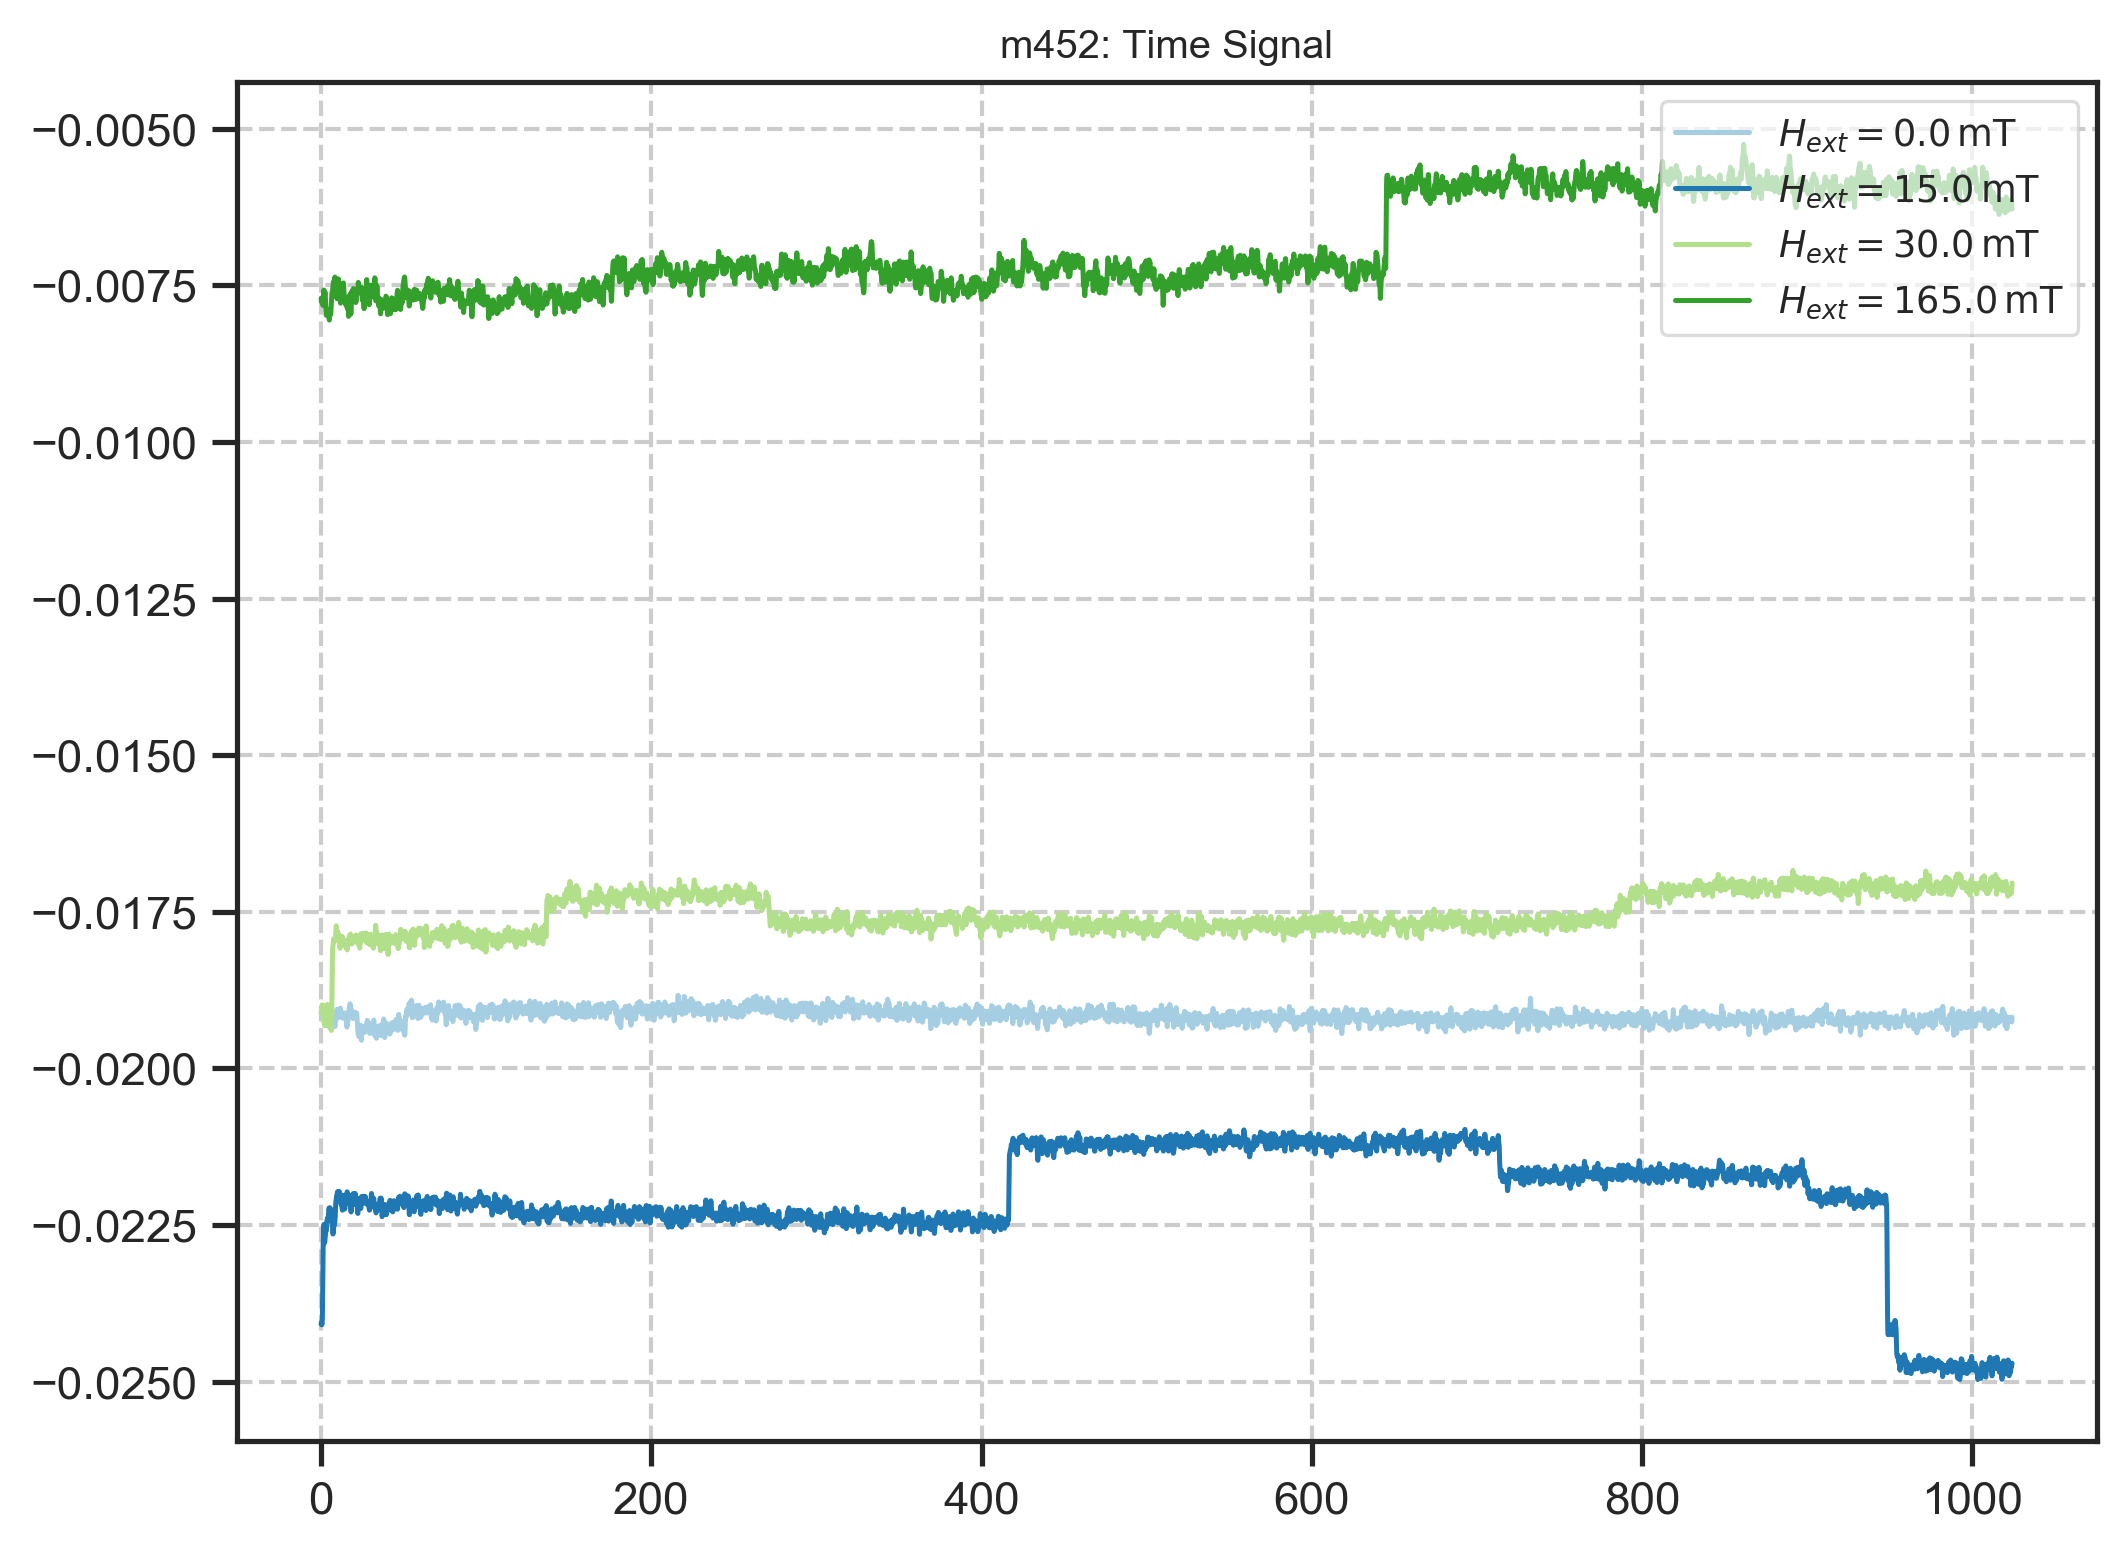

In [694]:
#fields = [.01, .015, .02, .025, .03, .04, .045]


eva.set_sns(notebook=True, palette='Paired', grid=True)
fig, ax = plt.subplots()#len(fields))
eva.set_sns(notebook=True, size='paper')
for i, f in enumerate(fields):
    signal = df[nr].query('Field == %.4f' % f)
    ax.plot(signal.Time, signal.Vx, label='$H_{ext} = %s\\,\\mathrm{mT}$' % (f*1e3))
ax.legend(loc='upper right', framealpha=.7)
ax.set_title("m%s: Time Signal" % (nr))
plt.savefig("m%s_Timesignal.png")

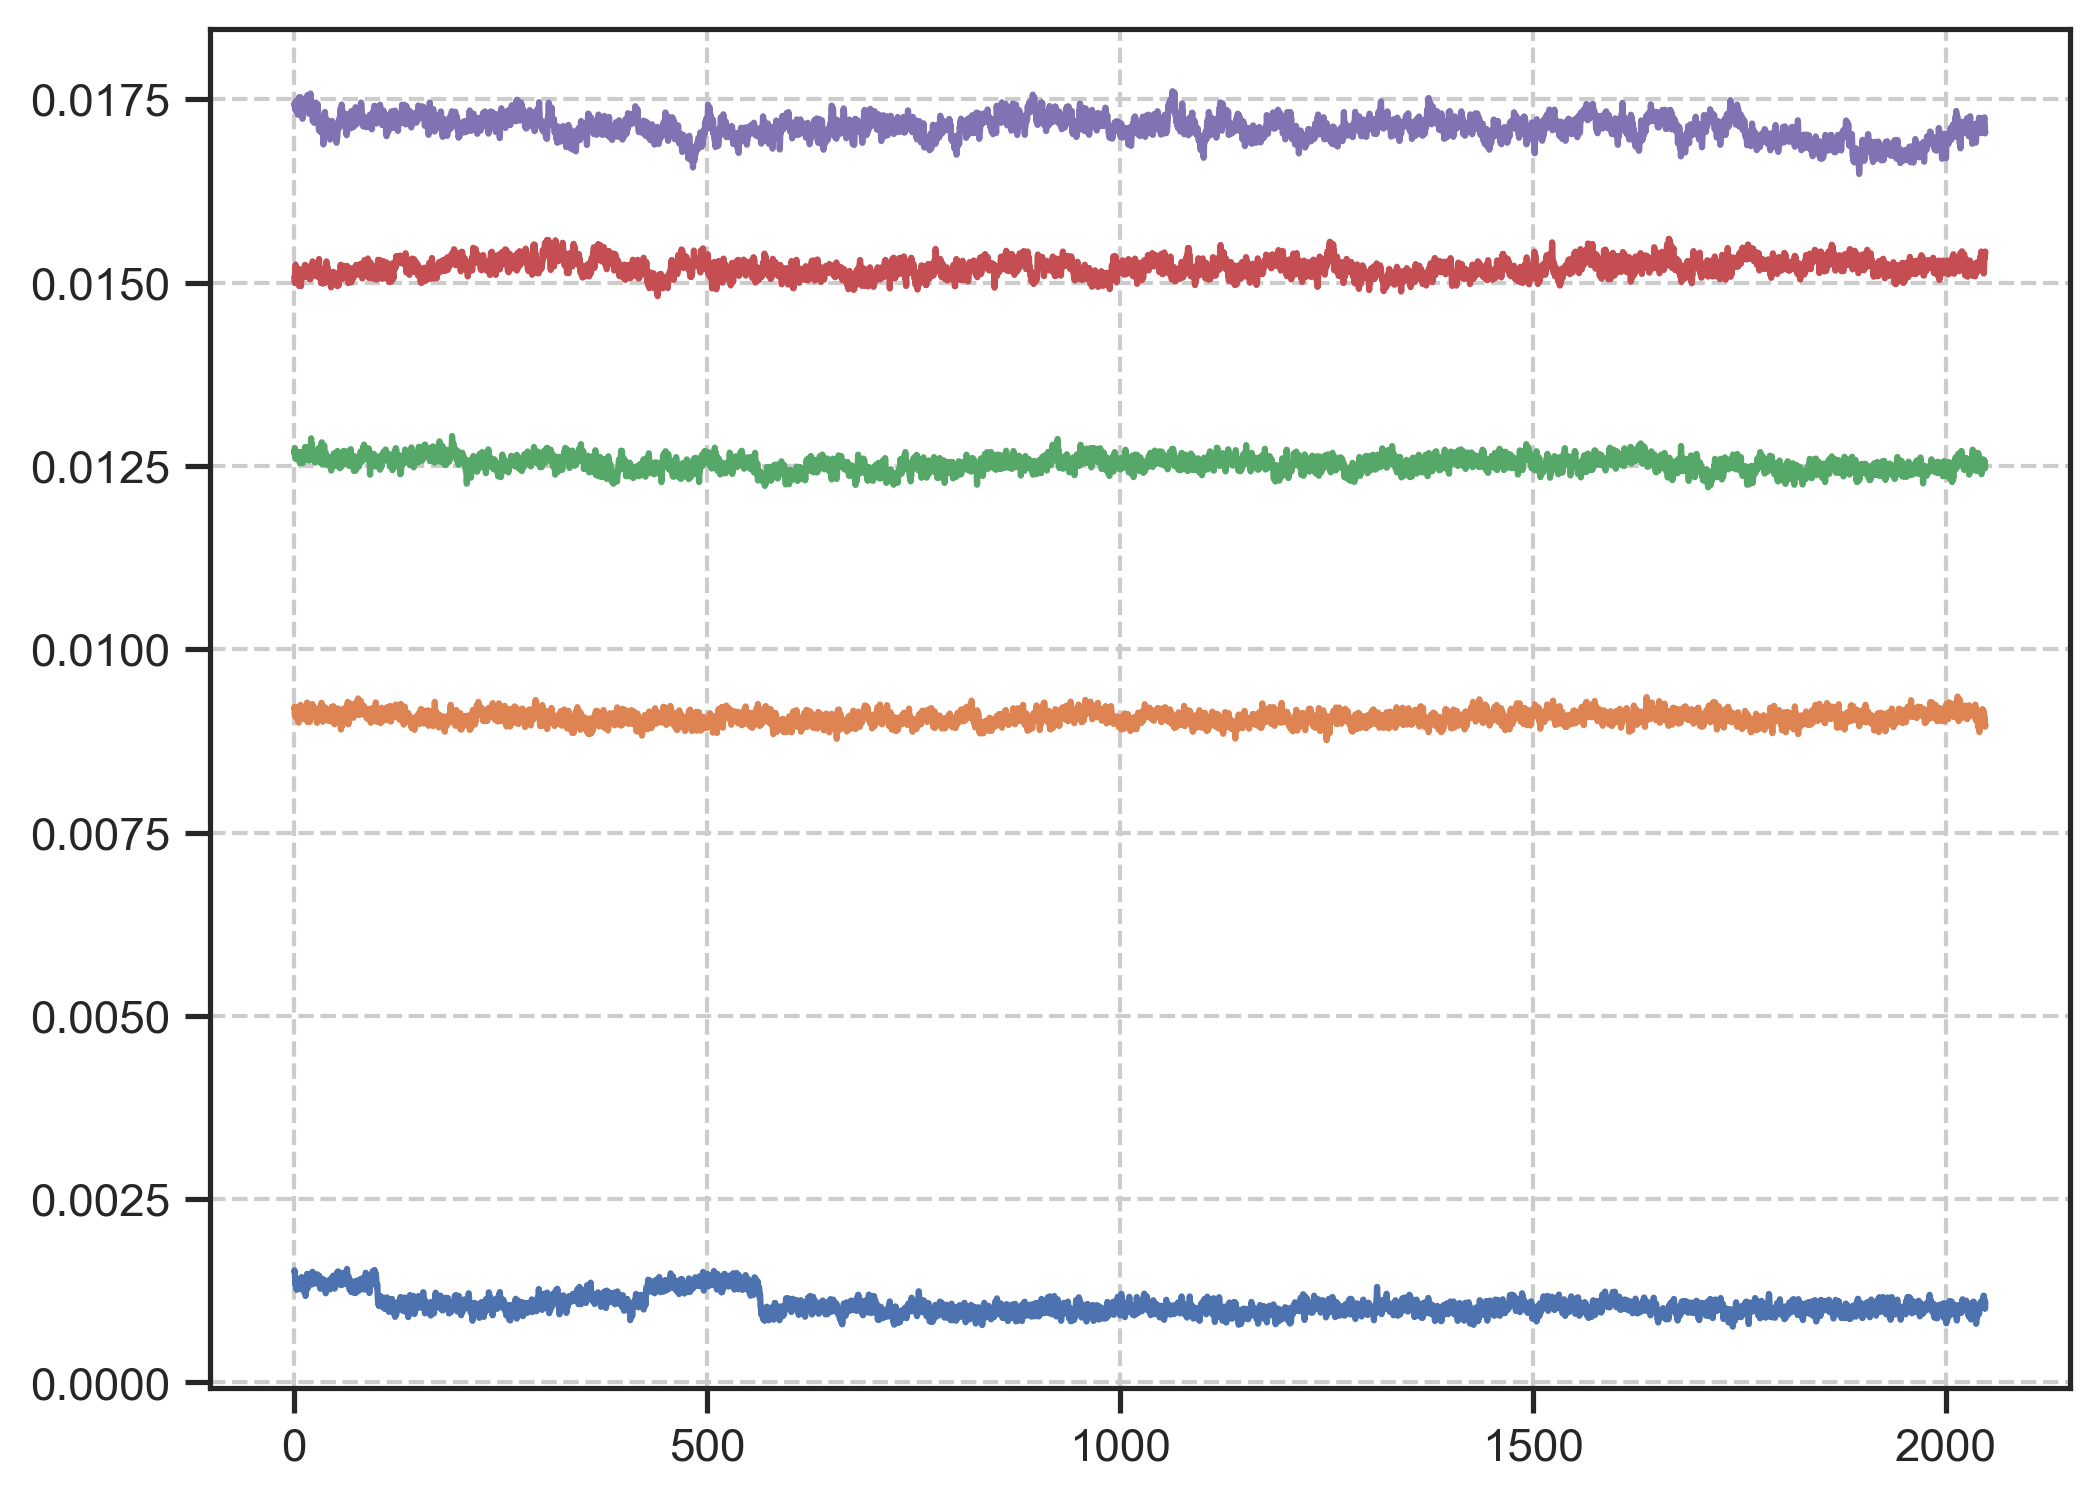

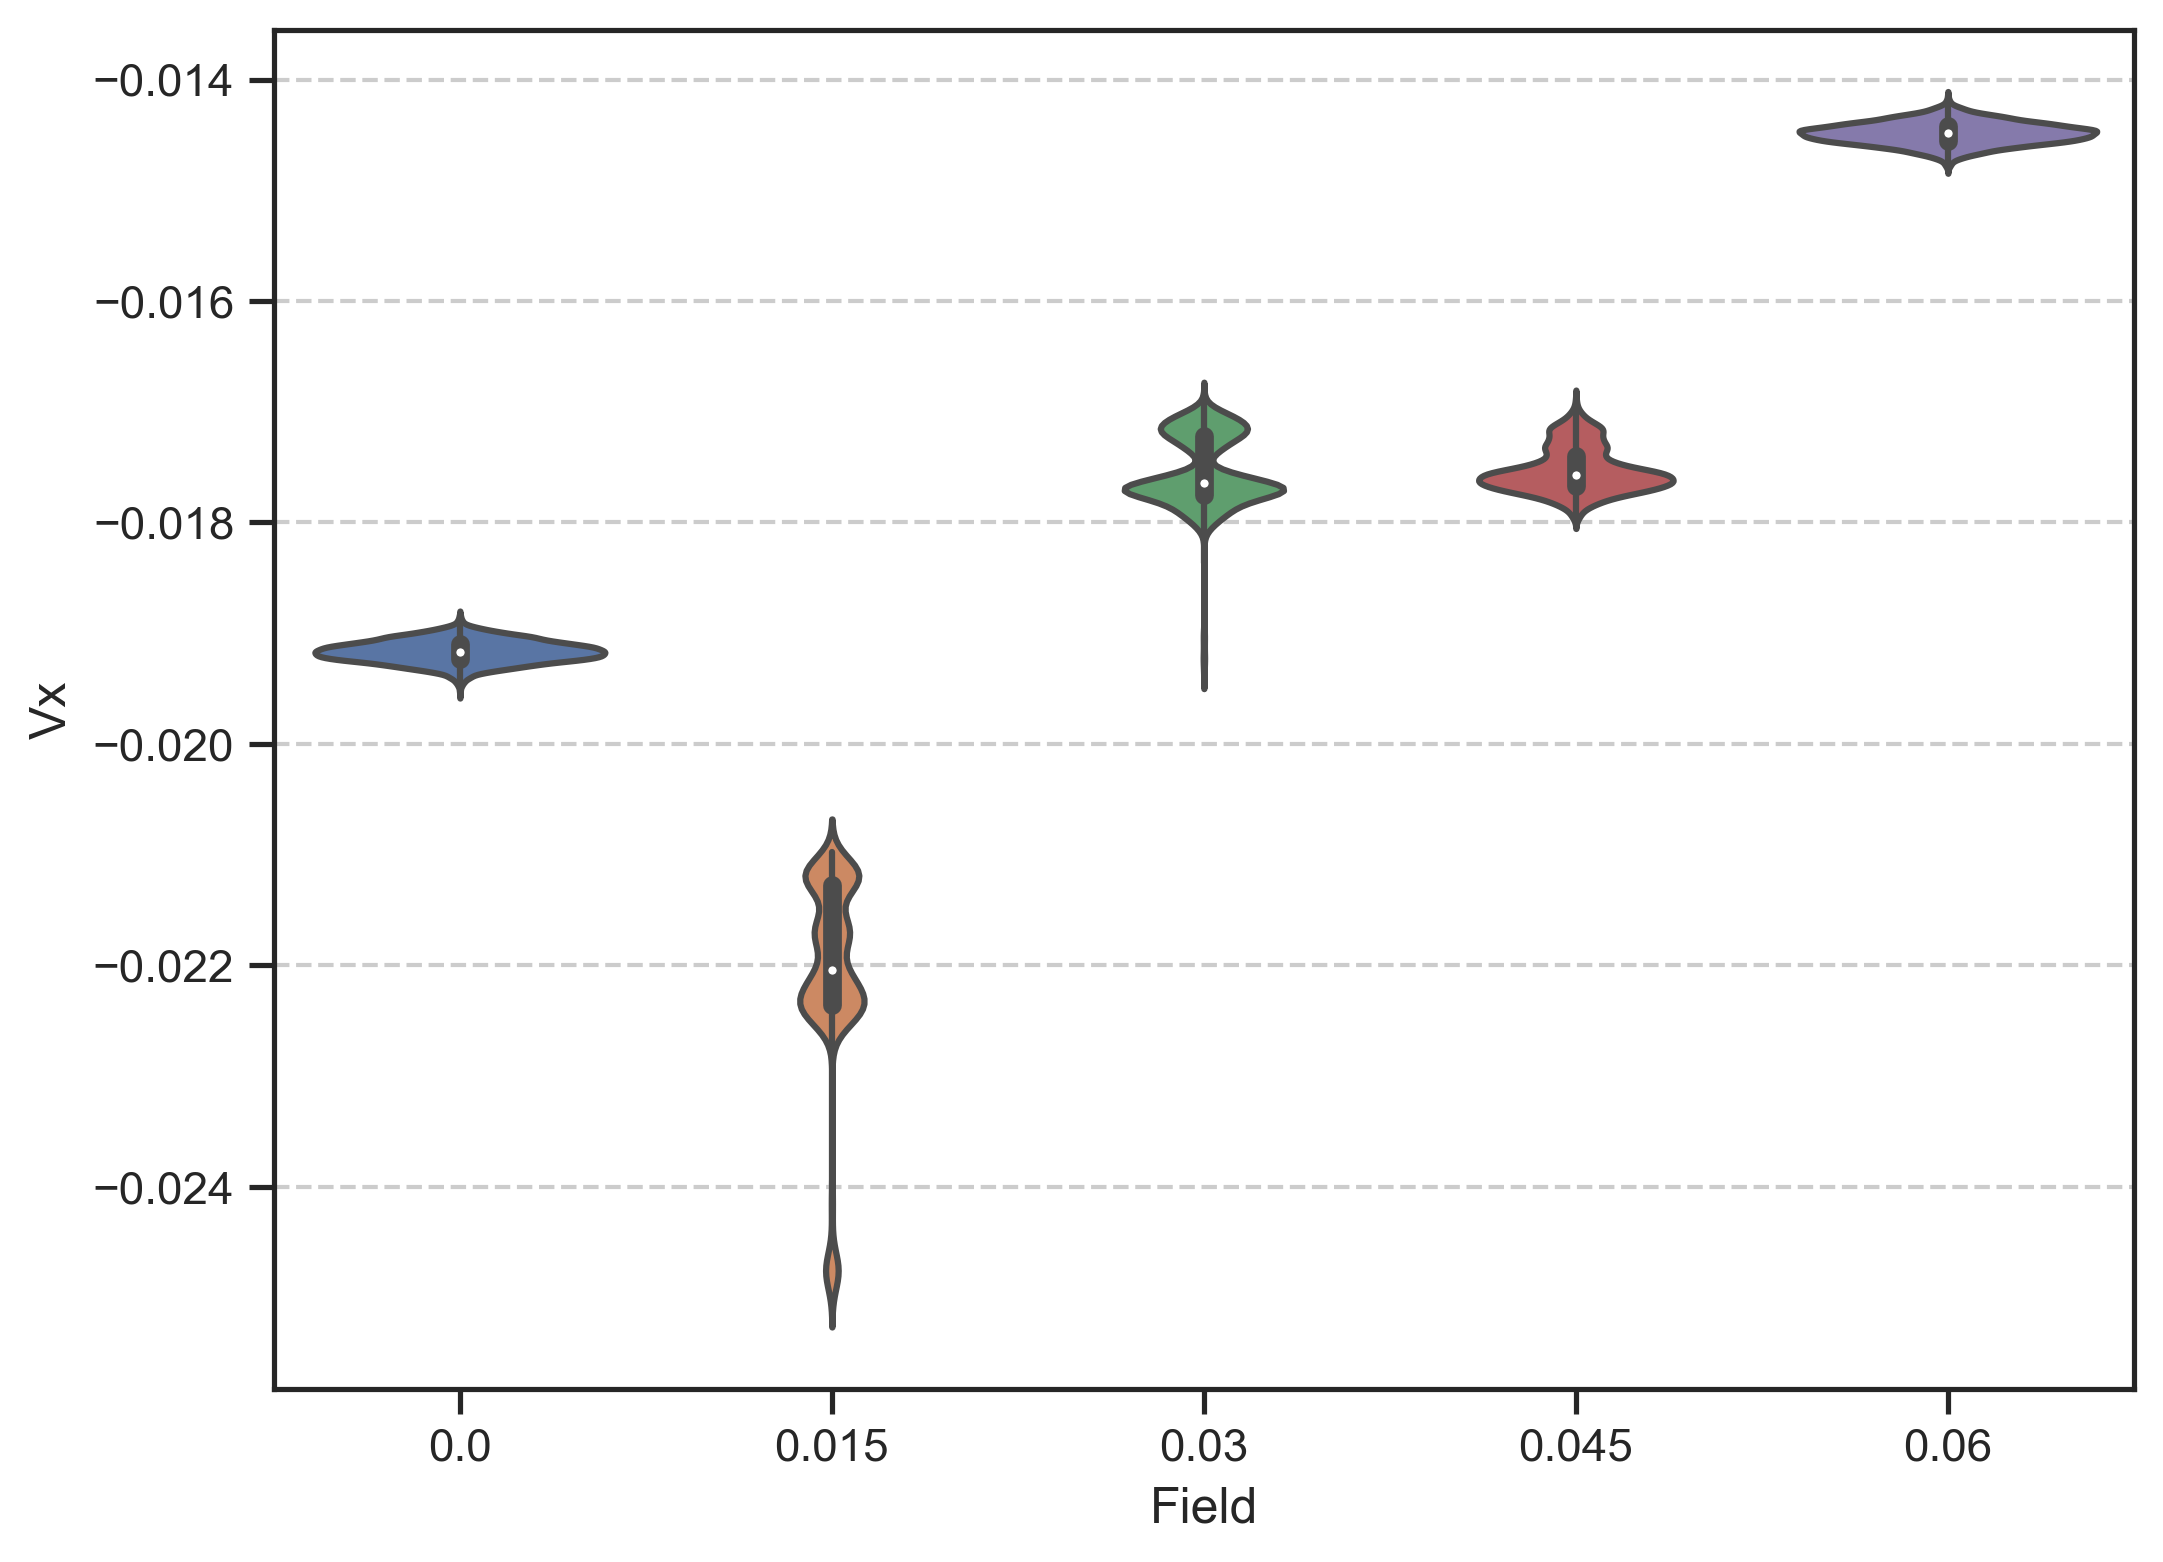

In [693]:
eva.set_sns(notebook=True, grid=True)
signal = df[nr].sort_values('Field').query('Field >= .0 and Field <= .06')
for f in signal.Field.unique():
    tmp_plot = df[446].query('Field == %s' % f)
    plt.plot(tmp_plot.Time, tmp_plot.Vx)

fig, ax = plt.subplots()
sns.violinplot(x='Field', y='Vx', data=signal, ax=ax)

## Plot Noise Spectrum Hysteresis

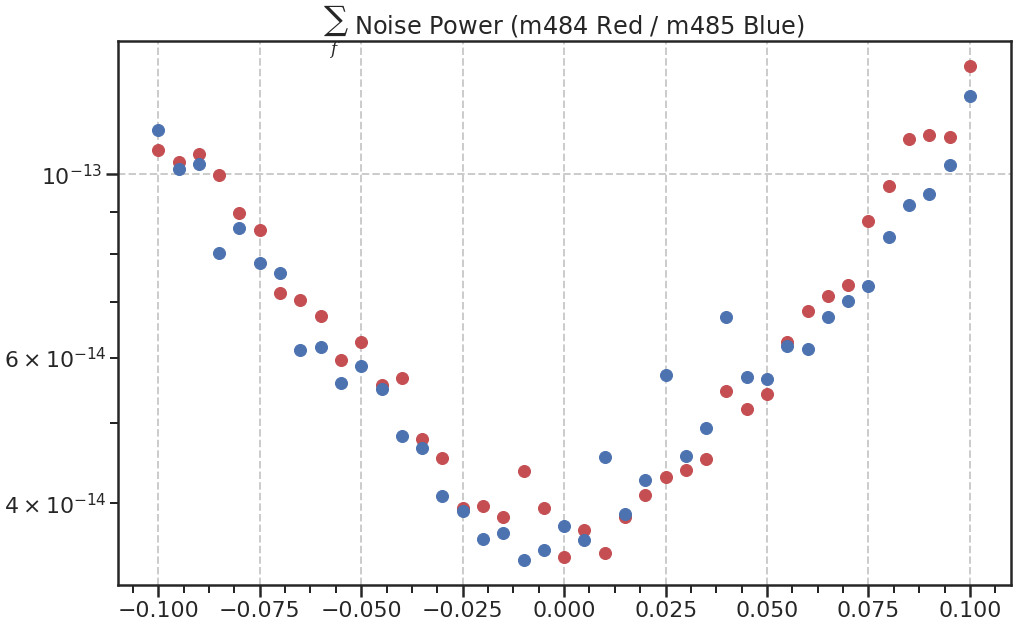

In [42]:
ana.set_sns(notebook=True, size='poster', palette='Paired', grid=True)
nr1, nr2 = 484, 485
plot_spectrum_hyst(nr1, nr2)

## Cut and Paste Timesignal (multiple Measurements)

### Test to put multiple measurements together

In [195]:
query = meas_info.query('Rate == 8 and Preamp == False and Struct == "Plusses" and ' +\
                'Voltage == 5 and Angle == 45 and Dir == "Up"')

raw_data = {}
query_fields = []
for nr in query.index:
    files = glob('data/Data/m%s/*' % nr)
    regex = ".*[Mm]([0-9.]*)_([A-Za-z]*)_([0-9.-]*)deg_([A-Za-z]*)_" \
                            +"([A-Za-z]*)_*B_([0-9.-]*)T_([0-9]*)_([0-9]*)_" \
                            +"I1-([0-9\-]*)_I2-([0-9\-]*)_GBIP.-([0-9\-]*)_" \
                            +"Vin-([0-9.]*)V_R11-([0-9]*.)O_R12-([0-9.]*.)O_" \
                            +"R13-([0-9.]*.)_R21-([0-9.]*.)O_" \
                            +"C11-([0-9]*)_C21-([0-9]*)_" \
                            +"T-([0-9]*)K.*"
    raw_data[nr] = {}
    for f in files:
        reg = re.match(regex, f)
        if not reg:
            logger.error("Regex doesn't match filename: %s" % f)
            continue

        nr2, struct, deg, type1, \
            type2, field, date, time, \
            i1, i2, lock_in, \
            vin, r11, r12, r13, r21, \
            c11, c21, Temp = reg.groups()

        field = float(field)
        if field not in query_fields:
            query_fields.append(field)

        data_df = pd.read_csv(f, sep='\t')
        raw_data[nr][field] = data_df


In [225]:
eval_data = {}
for field in query_fields:
    if abs(field) > .08:
        continue

    eval_data[field] = pd.DataFrame({'time':[], 'Vx':[], 'Vy':[]})

    for nr in query.index:
        if field in raw_data[nr].keys():
            if not eval_data[field].empty:
                raw_data[nr][field]['time'] += eval_data[field]['time'].max()
            
            eval_data[field] = pd.merge(eval_data[field], raw_data[nr][field], how='outer')


In [238]:
eval_spectrum = {}
for field in eval_data.keys():
    d = eval_data[field]['Vx']
    if len(d)%1024:
        d = d.iloc[:-(len(d)%1024)]

    data = {'data': d, 
            'info': {
                'nr': nr,
                'field': field
                }
            }

    eval_spectrum[field] = eva.RAW_Measurement(data, 
                                               rate=1/eval_data[field]['time'].diff().mean(),
                                               nof_first_spectra=64,
                                               calc_first=True,
                                               calc_second=True
                                              )

E:\Nextcloud\Uni\Evaluate\spectrumanalyzer.py:825: RuntimeWarning: invalid value encountered in true_divide
  second_spectra = second_spectra.transpose()
E:\Nextcloud\Uni\Evaluate\spectrumanalyzer.py:856: RuntimeWarning: divide by zero encountered in log10
  frequency_span_array_second_spectra > 0])
E:\Nextcloud\Uni\Evaluate\evaluate.py:875: RuntimeWarning: invalid value encountered in true_divide
  time_signal_second_spectrum_transposed[p])


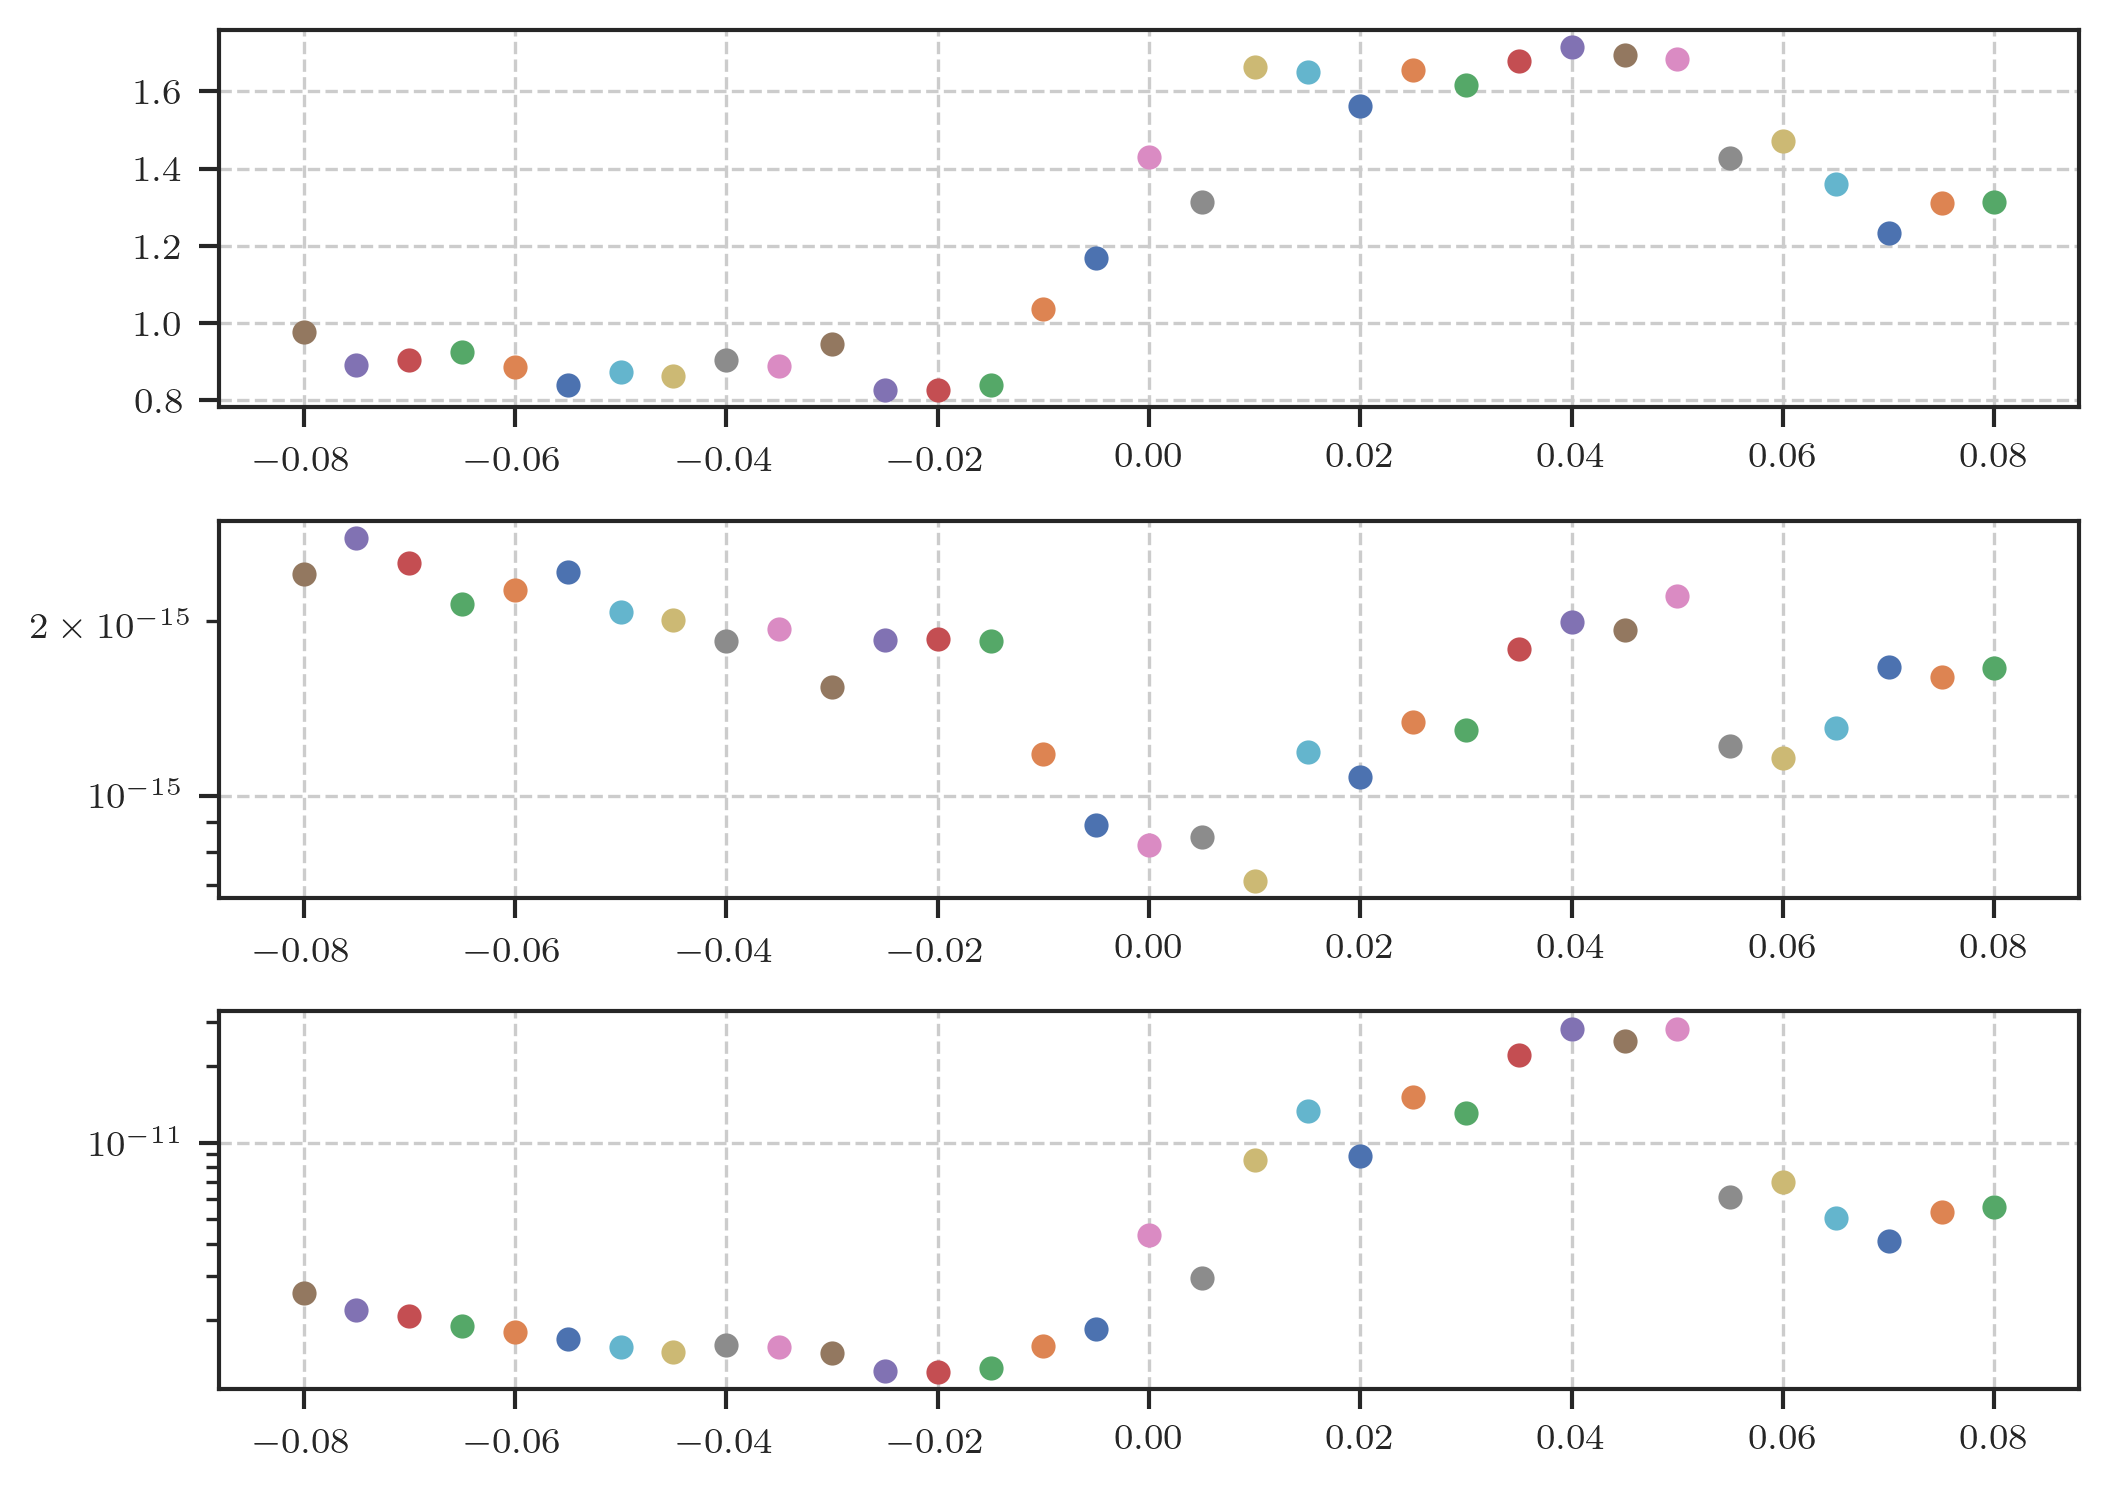

In [240]:
fit_range = 50
fig, (ax1,ax2,ax3) = plt.subplots(3)
for cur_field, cur_spectrum in eval_spectrum.items():
    s = cur_spectrum.avg_spec
    
    # Fitting alpha
    s['lnf'] = np.log10(s.freq)
    s['lnS'] = np.log10(s.S)

    f = scipy.stats.linregress(s.lnf.iloc[:fit_range], 
                               s.lnS.iloc[:fit_range])
    
    ax1.plot(cur_field, -f.slope, 'o')
    ax2.plot(cur_field, 10**f.intercept, 'o')
    ax3.plot(cur_field, s.S.sum(), 'o')
ax2.set_yscale('log')
ax3.set_yscale('log')

### Evaluating m456 (multiple measurements at 0 field)

In [705]:
nr = 456
files = glob('data/Data/m%s/*' % nr)
m456_df = pd.DataFrame({'time':[], 'Vx':[], 'Vy':[]})
for f in files:
    tmp_df = pd.read_csv(f, sep='\t')
    if not m456_df.empty:
        tmp_df['time'] += m456_df['time'].max()
    
    m456_df = pd.merge(m456_df, tmp_df, how='outer')

d = m456_df['Vx']
if len(d)%1024:
    d = d.iloc[:-(len(d)%1024)]

data = {'data': d, 
        'info': {
            'nr': nr,
            'field': field
            }
        }

m456_spectrum = eva.RAW_Measurement(data, 
                                           rate=1/m456_df['time'].diff().mean(),
                                           nof_first_spectra=64,
                                           calc_first=True,
                                           calc_second=True
                                          )


#### First Spectrum

Slope:	-0.742
Interc:	2.8610e-15
Sum:	3.0521e-11


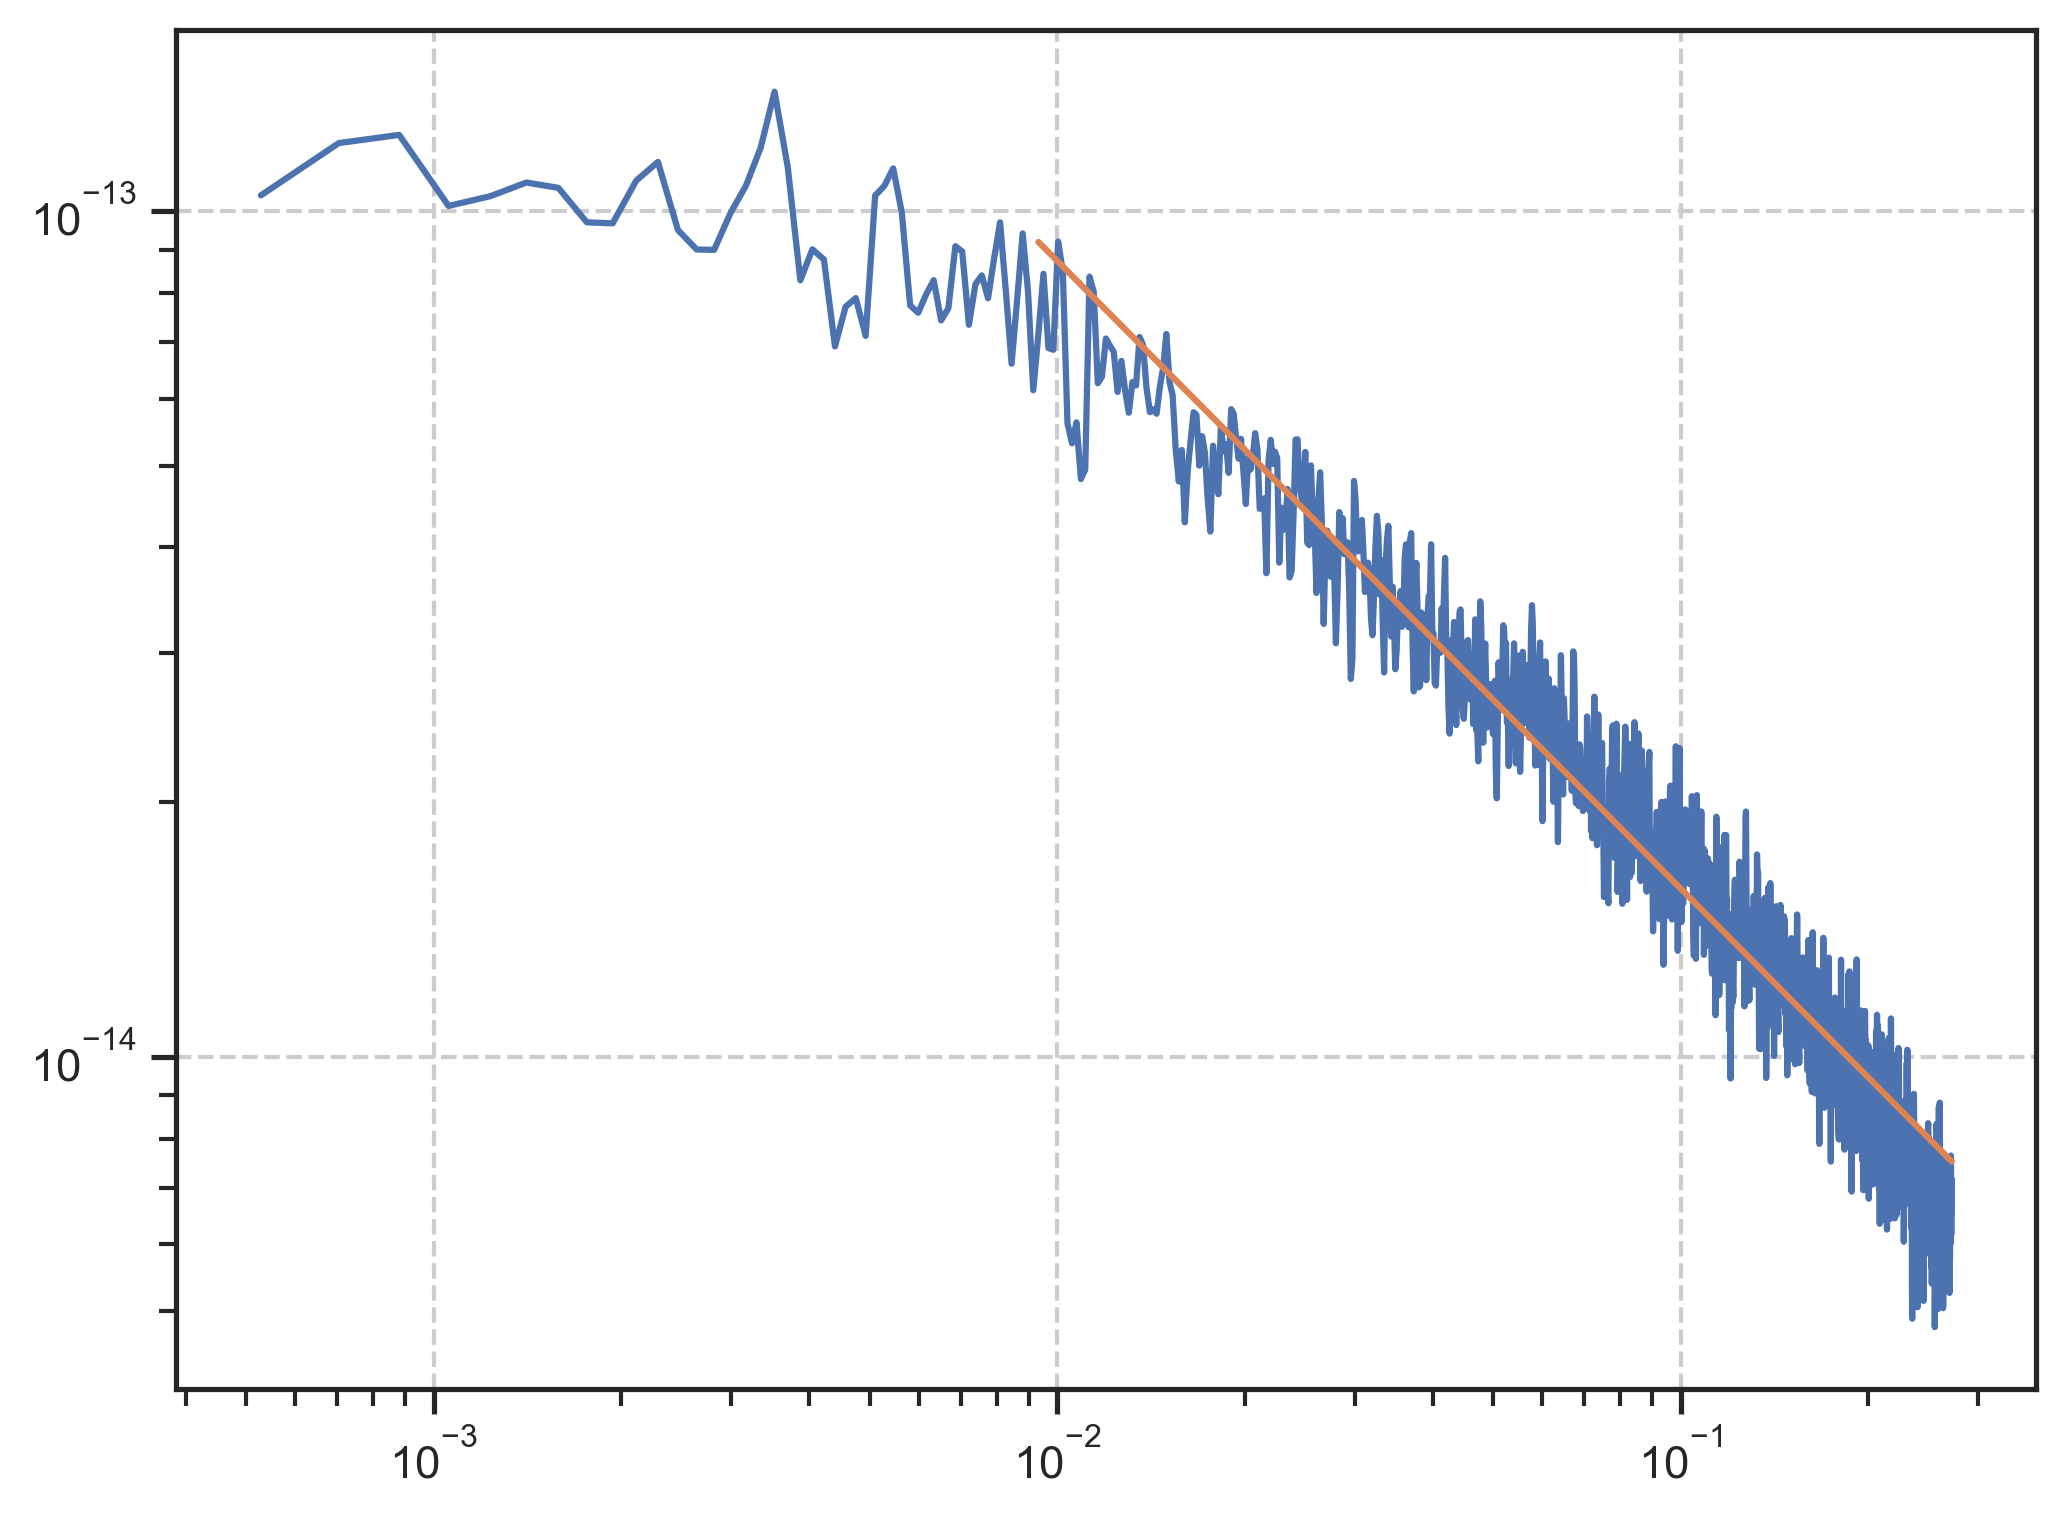

In [309]:
eva.set_sns(size='notebook', style='ticks', grid=True)
s = m456_spectrum.avg_spec
fit_start = 50
fit_range = 1300
fig, (ax1) = plt.subplots()
# Fitting alpha
s['lnf'] = np.log10(s.freq)
s['lnS'] = np.log10(s.S)

f = scipy.stats.linregress(s.lnf.iloc[fit_start:fit_range], 
                           s.lnS.iloc[fit_start:fit_range])

ax1.loglog(s.freq, s.S)
ax1.loglog(s.freq.iloc[fit_start:], 10**(f.intercept)*s.freq.iloc[fit_start:]**f.slope)
print("Slope:\t%.3f\nInterc:\t%.4e\nSum:\t%.4e" % (f.slope, 10**f.intercept, s.S.sum()))

#### Histogram

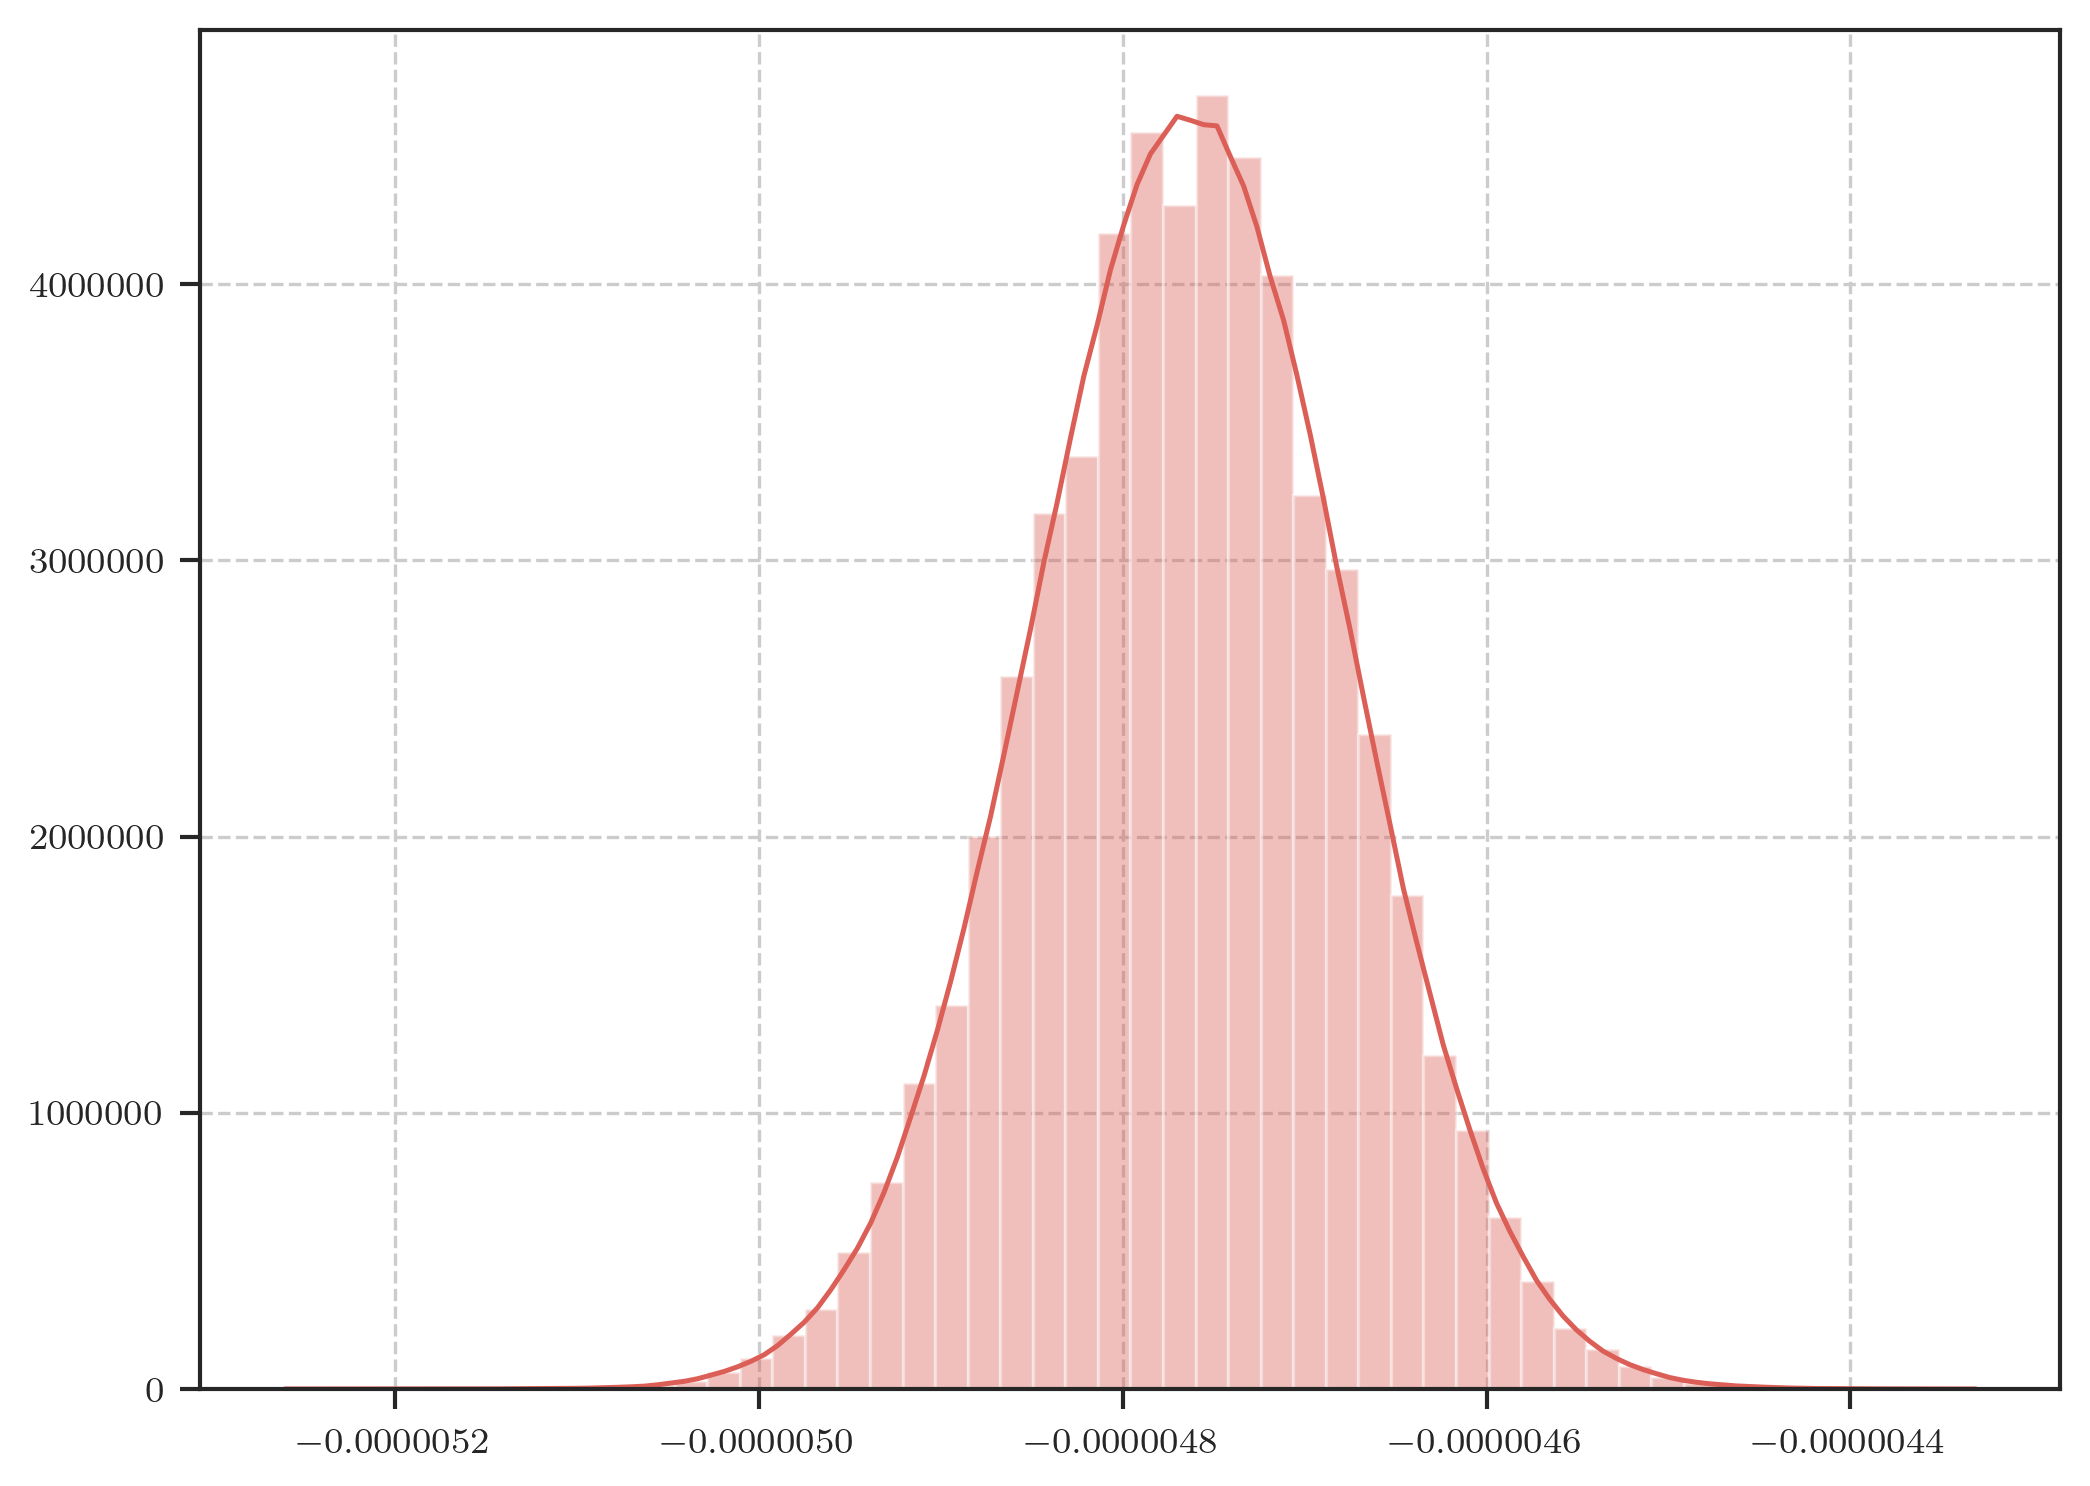

In [302]:
sns.distplot(m456_spectrum.timesignal)

#### Second Spectrum

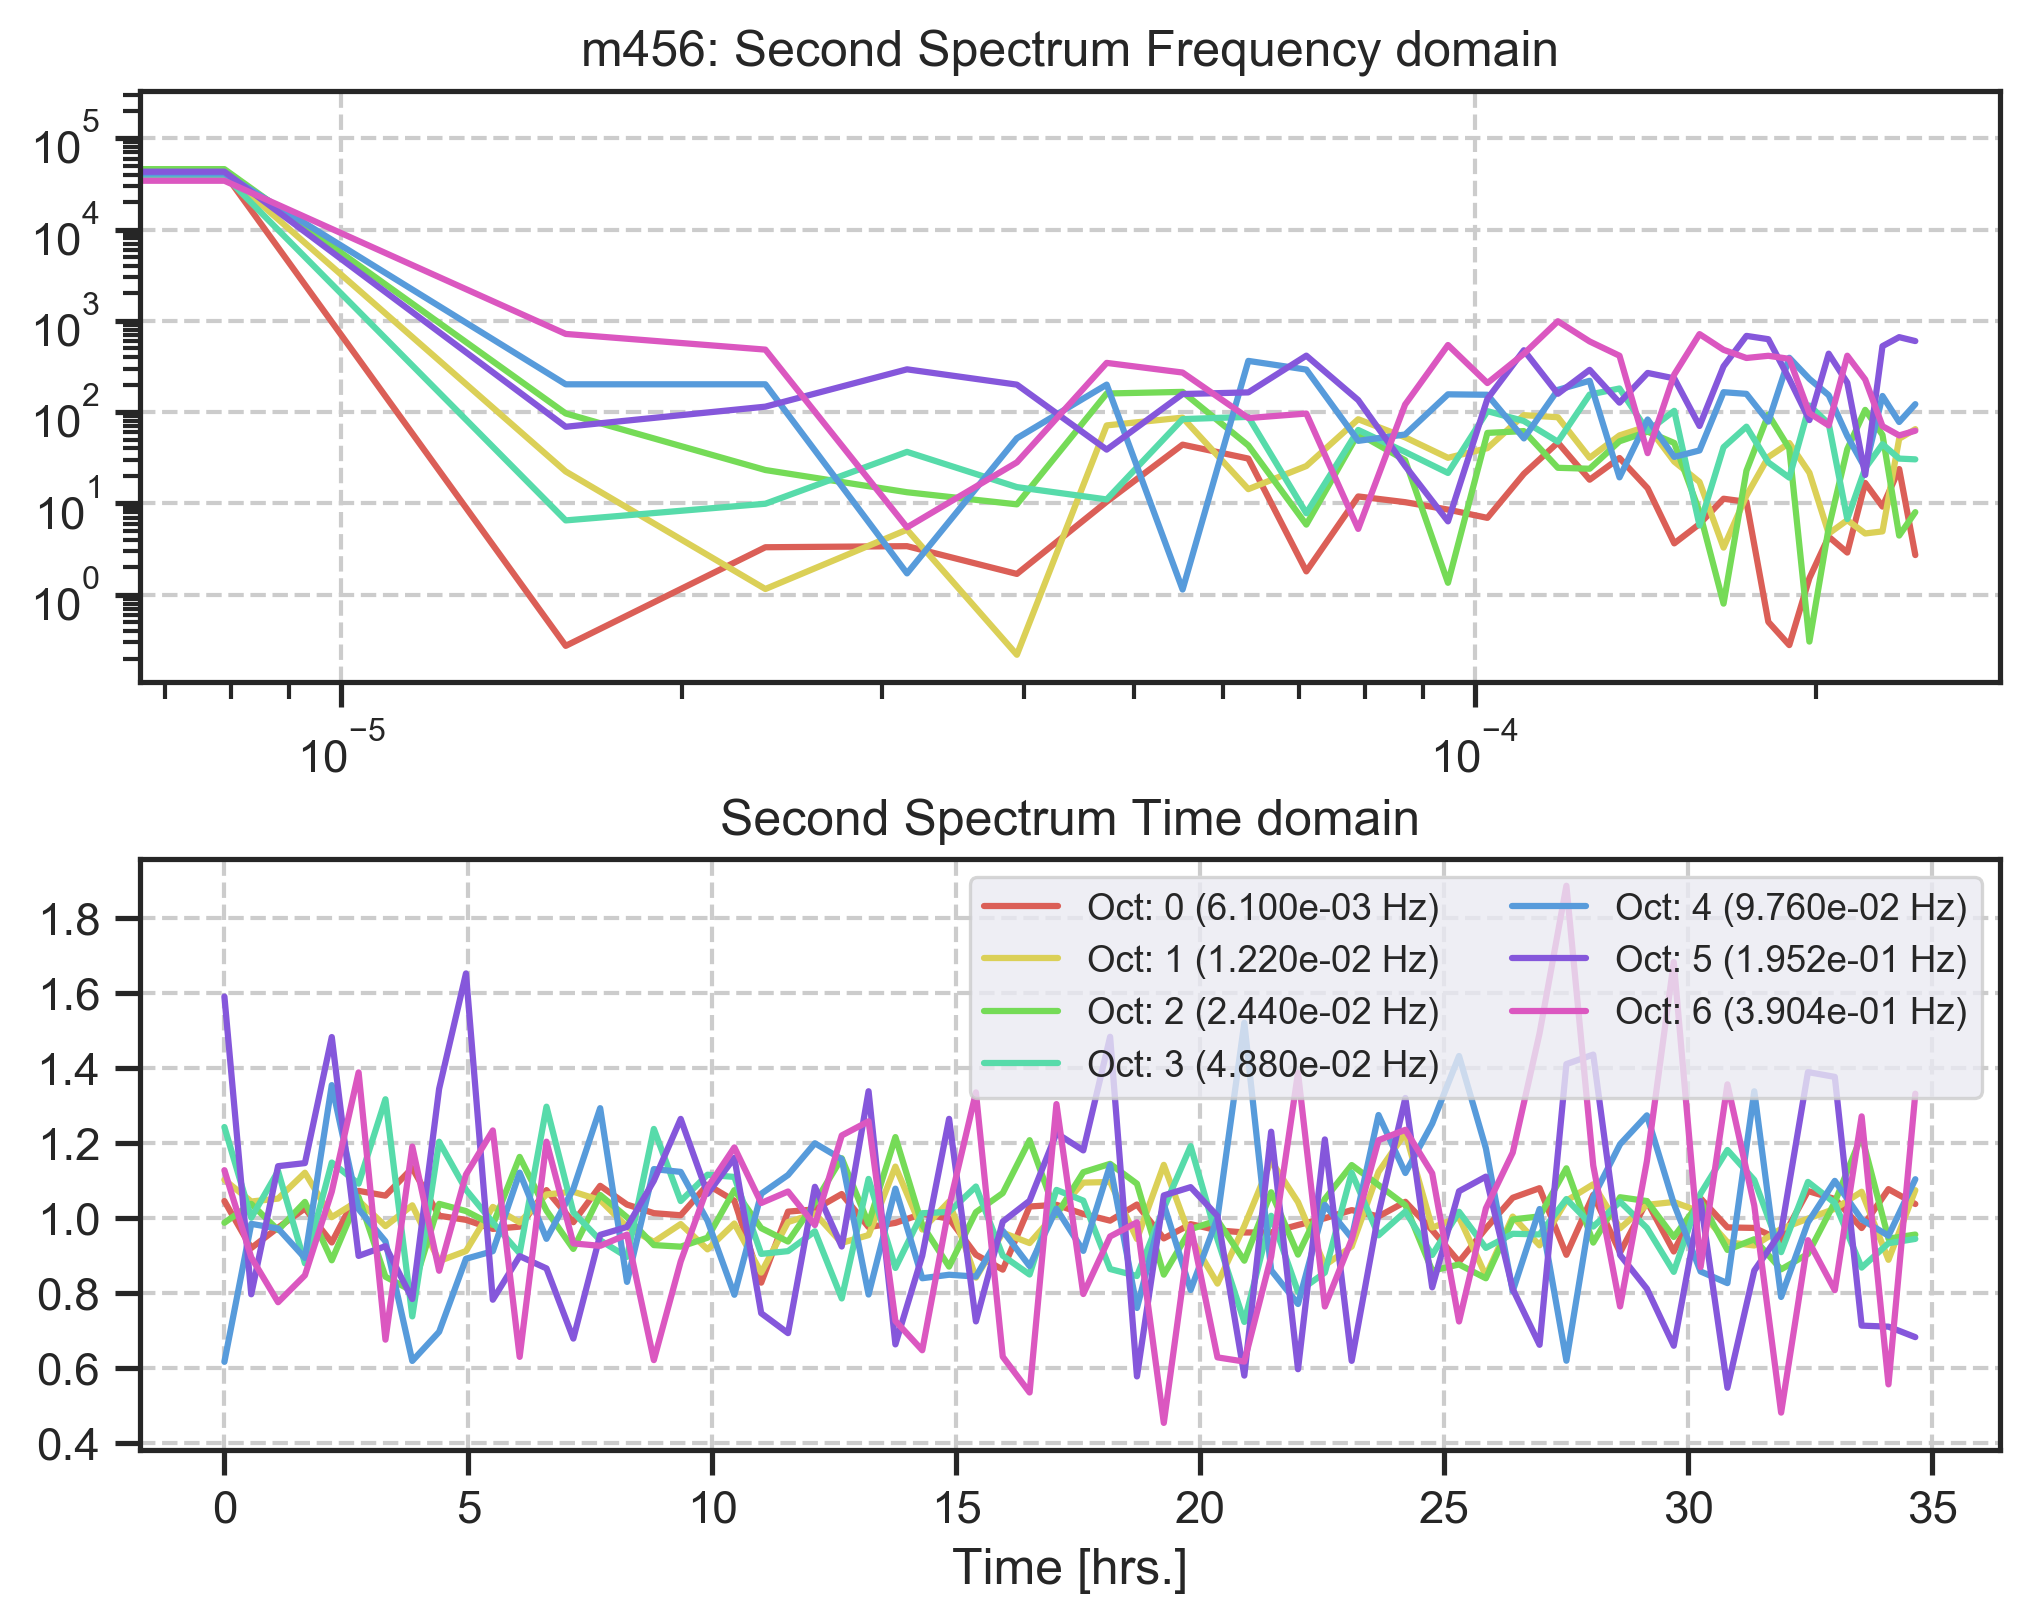

In [710]:
eva.set_sns(notebook=True, palette='Dark2', grid=True)
sns.set_palette('hls', m456_spectrum.spectrum.number_of_octaves)
nr = 456

fig, (ax, ax2) = plt.subplots(2)
for octave in range(m456_spectrum.spectrum.number_of_octaves):
    ax.plot(m456_spectrum.spectrum.frequency_span_array_second_spectra, 
             m456_spectrum.spectrum.second_spectra[octave],
            label='Oct: %d' % (octave))
    ax2.plot(m456_spectrum.second_spectrum_time_array/(60*60), 
             m456_spectrum.time_signal_second_spectrum_transposed_normalized[octave],
            label='Oct: %d (%.3e Hz)' % (octave, m456_spectrum.spectrum.octaves[octave]))
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_title('m%s: Second Spectrum Frequency domain' % nr)
ax2.set_title('Second Spectrum Time domain')
ax2.set_xlabel("Time [hrs.]")

eva.set_sns(size='paper')
ax2.legend(loc='upper right', ncol=2)
plt.savefig('m%s_second_spectrum.png' % nr)